### Loading Packages and Data

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 8)

#import xarray as xr
import warnings
warnings.filterwarnings('ignore')
from matplotlib.backends.backend_pdf import PdfPages

from db_queries import get_outputs as go
from db_queries import get_ids
from get_draws.api import get_draws

In [2]:
ls /mnt/team/simulation_science/priv/engineering/vivarium_nih_us_cvd/test_run_no_treatment/alabama/2023_06_14_02_31_35/count_data

deaths.csv              risk_exposure_time.hdf  transition_count.csv  ylds.hdf
deaths.hdf              state_person_time.csv   transition_count.hdf  ylls.csv
risk_exposure_time.csv  state_person_time.hdf   ylds.csv              ylls.hdf


In [3]:
sim_results_dir = '/mnt/team/simulation_science/priv/engineering/vivarium_nih_us_cvd/test_run_no_treatment/alabama/2023_06_14_02_31_35/count_data/'

### Exploring Data

In [4]:
deaths = pd.read_csv(sim_results_dir + 'deaths.csv')
deaths.head()

,Unnamed: 0,sex,year,cause,measure,input_draw,scenario,age,value
0,0,female,2023,acute_ischemic_stroke,deaths,29,baseline,25_to_29,1.0
1,1,female,2023,acute_ischemic_stroke,deaths,29,lifestyle_100,25_to_29,1.0
2,2,female,2023,acute_ischemic_stroke,deaths,29,lifestyle_50,25_to_29,1.0
3,3,female,2023,acute_ischemic_stroke,deaths,29,outreach_100,25_to_29,1.0
4,4,female,2023,acute_ischemic_stroke,deaths,29,outreach_50,25_to_29,1.0


In [5]:
state_person_time = pd.read_csv(sim_results_dir + '/state_person_time.csv')
person_time = state_person_time.loc[state_person_time['state'].isin(["ischemic_stroke_acute_ischemic_stroke", "ischemic_stroke_chronic_ischemic_stroke", "ischemic_stroke_susceptible_to_ischemic_stroke"])].reset_index() 
person_time.value.sum()

692360815.2334018

In [6]:
person_time_test = state_person_time.loc[state_person_time['state'].isin(["ischemic_heart_disease_and_heart_failure_acute_myocardial_infarction_and_heart_failure", "ischemic_heart_disease_and_heart_failure_acute_myocardial_infarction", "ischemic_heart_disease_and_heart_failure_heart_failure_from_ischemic_heart_disease", "ischemic_heart_disease_and_heart_failure_heart_failure_residual", "ischemic_heart_disease_and_heart_failure_post_myocardial_infarction", "ischemic_heart_disease_and_heart_failure_susceptible_to_ischemic_heart_disease_and_heart_failure"])].reset_index() 
person_time_test.value.sum()

692360815.2334017

### Total DALYs by Year

In [7]:
yll = pd.read_csv(sim_results_dir + 'ylls.csv')
yll = yll.rename(columns = {'value':'yll'})
yll_total = yll.groupby(['sex', 'age', 'input_draw', 'year']).yll.sum().reset_index()
yld = pd.read_csv(sim_results_dir + 'ylds.csv')
yld = yld.rename(columns = {'value':'yld'})
yld_total = yld.groupby(['sex', 'age', 'input_draw', 'year']).yld.sum().reset_index()
daly_total = pd.concat([yll_total, yld_total.yld], axis=1)
daly_total['daly'] = daly_total['yll'] + daly_total['yld'] 

daly_total.head()

,sex,age,input_draw,year,yll,yld,daly
0,female,25_to_29,29,2023,14633.536597,378.387514,15011.924111
1,female,25_to_29,29,2024,10288.496431,438.362149,10726.858580
2,female,25_to_29,29,2025,11725.291363,473.370768,12198.662131
3,female,25_to_29,29,2026,14246.691560,487.483130,14734.174690
4,female,25_to_29,29,2027,10822.069827,523.239173,11345.309000


In [8]:
daly_sum = (daly_total
                .groupby(['year'])
                .daly.describe(percentiles=[.025, .975])
                .filter(['mean', '2.5%', '97.5%'])
                .reset_index())

daly_sum.head()

,year,mean,2.5%,97.5%
0,2023,43944.606351,6190.563218,94523.806733
1,2024,44450.295547,6208.190593,97578.517603
2,2025,44673.436353,6245.696587,96011.703777
3,2026,45077.778582,6124.324715,95772.908368
4,2027,45321.230986,5733.539740,98978.899469


### All Cause Mortality Graphs

In [9]:
result_summary = (deaths
                      .groupby(['age', 'sex', 'year'])
                      .value.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

result_summary.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,female,2023,4.1375,0.0,17.100
1,25_to_29,female,2024,4.0625,0.0,14.075
2,25_to_29,female,2025,4.1000,0.0,15.050
3,25_to_29,female,2026,4.3000,0.0,16.050
4,25_to_29,female,2027,3.8000,0.0,16.025


#### All Cause Mortality Graph with Rate

In [10]:
person_time = person_time.rename(columns = {'value':'ptvalue'})
per_time_group = person_time.groupby(['age', 'sex', 'year', 'input_draw']).ptvalue.sum().reset_index()

per_time_group.head()

,age,sex,year,input_draw,ptvalue
0,25_to_29,female,2023,29,189136.646133
1,25_to_29,female,2023,232,189399.589322
2,25_to_29,female,2023,357,187971.646817
3,25_to_29,female,2023,394,188172.342231
4,25_to_29,female,2023,602,185783.852156


In [11]:
results_rate = deaths.groupby(['age', 'sex', 'year', 'input_draw']).value.sum().reset_index()
results_rate = pd.concat([results_rate, per_time_group.ptvalue], axis=1)
results_rate['mean_rate'] = results_rate['value'] / results_rate['ptvalue']
result_summary = (results_rate
                      .groupby(['age', 'sex', 'year'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

result_summary.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,female,2023,0.001233,0.000581,0.001927
1,25_to_29,female,2024,0.001224,0.000799,0.002201
2,25_to_29,female,2025,0.001246,0.000901,0.001972
3,25_to_29,female,2026,0.001316,0.000713,0.001995
4,25_to_29,female,2027,0.001168,0.000609,0.001629


### Cause Specific Mortality Graphs
#### Acute Stroke

In [12]:
deaths_cause = (deaths
               .groupby(['age', 'sex', 'year', 'cause'])
               .value.describe(percentiles=[.025, .975])
               .filter(['mean', '2.5%', '97.5%'])
               .reset_index())

acute = deaths_cause.loc[(deaths_cause['cause'] == 'acute_ischemic_stroke')].reset_index()

acute.head()

,index,age,sex,year,cause,mean,2.5%,97.5%
0,0,25_to_29,female,2023,acute_ischemic_stroke,0.5,0.0,2.0
1,8,25_to_29,female,2024,acute_ischemic_stroke,0.4,0.0,4.0
2,16,25_to_29,female,2025,acute_ischemic_stroke,0.6,0.0,2.0
3,24,25_to_29,female,2026,acute_ischemic_stroke,0.2,0.0,2.0
4,32,25_to_29,female,2027,acute_ischemic_stroke,0.1,0.0,1.0


In [13]:
death_rate_cause = deaths.groupby(['age', 'sex', 'year', 'input_draw', 'cause']).value.sum().reset_index()
acute_rate = death_rate_cause.loc[(death_rate_cause['cause'] == 'acute_ischemic_stroke')].reset_index()
acute_rate.head()

,index,age,sex,year,input_draw,cause,value
0,0,25_to_29,female,2023,29,acute_ischemic_stroke,7.0
1,8,25_to_29,female,2023,232,acute_ischemic_stroke,0.0
2,16,25_to_29,female,2023,357,acute_ischemic_stroke,14.0
3,24,25_to_29,female,2023,394,acute_ischemic_stroke,14.0
4,32,25_to_29,female,2023,602,acute_ischemic_stroke,0.0


In [14]:
acute_rate_2 = pd.concat([acute_rate, per_time_group.ptvalue], axis=1)
acute_rate_2['mean_rate'] = acute_rate_2['value'] / acute_rate_2['ptvalue']

acute_rate_summary = (acute_rate_2
                      .groupby(['age', 'sex', 'year'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

acute_rate_summary.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,female,2023,0.000019,0.0,0.000074
1,25_to_29,female,2024,0.000015,0.0,0.000116
2,25_to_29,female,2025,0.000023,0.0,0.000077
3,25_to_29,female,2026,0.000008,0.0,0.000060
4,25_to_29,female,2027,0.000004,0.0,0.000030


#### Chronic Stroke

In [15]:
chronic_rate = death_rate_cause.loc[(death_rate_cause['cause'] == 'chronic_ischemic_stroke')].reset_index()
chronic_rate = pd.concat([chronic_rate, per_time_group.ptvalue], axis=1)
chronic_rate['mean_rate'] = chronic_rate['value'] / chronic_rate['ptvalue']
chronic_rate_summ = (chronic_rate
                      .groupby(['age', 'sex', 'year'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

chronic_rate_summ

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,female,2023,0.000000,0.000000,0.000000
1,25_to_29,female,2024,0.000000,0.000000,0.000000
2,25_to_29,female,2025,0.000000,0.000000,0.000000
3,25_to_29,female,2026,0.000000,0.000000,0.000000
...,...,...,...,...,...,...
536,95_plus,male,2037,0.008013,0.000887,0.017622
537,95_plus,male,2038,0.006061,0.002142,0.009308
538,95_plus,male,2039,0.008208,0.002057,0.019742
539,95_plus,male,2040,0.009723,0.006848,0.012988


#### Acute Myocardial Infarction - includes both heart failure and no heart failure

In [16]:
acute_MI_rate = death_rate_cause.loc[(death_rate_cause['cause'] == 'acute_myocardial_infarction') | (death_rate_cause['cause'] == 'acute_myocardial_infarction_and_heart_failure')].reset_index()
acute_MI_rate = acute_MI_rate.merge(per_time_group[['age','sex','year','input_draw','ptvalue']], on=['age','sex','year','input_draw'])
acute_MI_rate['mean_rate'] = acute_MI_rate['value'] / acute_MI_rate['ptvalue']
acute_MI_rate_summ = (acute_MI_rate
                      .groupby(['age', 'sex', 'year'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

acute_MI_rate_summ.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,female,2023,0.000123,0.0,0.000621
1,25_to_29,female,2024,0.000132,0.0,0.000817
2,25_to_29,female,2025,0.000126,0.0,0.000613
3,25_to_29,female,2026,0.000125,0.0,0.000575
4,25_to_29,female,2027,0.000112,0.0,0.000404


#### Post Myocaridal Infarction

In [17]:
post_MI_rate = death_rate_cause.loc[(death_rate_cause['cause'] == 'post_myocardial_infarction')].reset_index()
post_MI_rate = pd.concat([post_MI_rate, per_time_group.ptvalue], axis=1)
post_MI_rate['mean_rate'] = post_MI_rate['value'] / post_MI_rate['ptvalue']
post_MI_rate_summ = (post_MI_rate
                      .groupby(['age', 'sex', 'year'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

post_MI_rate_summ.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,female,2023,0.000127,0.000008,0.000253
1,25_to_29,female,2024,0.000143,0.000008,0.000414
2,25_to_29,female,2025,0.000110,0.000009,0.000316
3,25_to_29,female,2026,0.000161,0.000000,0.000395
4,25_to_29,female,2027,0.000135,0.000000,0.000368


#### Heart Failure

In [18]:
HF_rate = death_rate_cause.loc[(death_rate_cause['cause'] == 'heart_failure_from_ischemic_heart_disease') | (death_rate_cause['cause'] == 'heart_failure_residual')].reset_index()
HF_rate = HF_rate.merge(per_time_group[['age','sex','year','input_draw','ptvalue']], on=['age','sex','year','input_draw'])
HF_rate['mean_rate'] = HF_rate['value'] / HF_rate['ptvalue']
HF_rate_summ = (HF_rate
                      .groupby(['age', 'sex', 'year'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

HF_rate_summ.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,female,2023,0.000209,0.0,0.000582
1,25_to_29,female,2024,0.000205,0.0,0.000526
2,25_to_29,female,2025,0.000243,0.0,0.000607
3,25_to_29,female,2026,0.000218,0.0,0.000588
4,25_to_29,female,2027,0.000175,0.0,0.000527


### Excess Mortality rate

#### Post Myocardial Infarction

In [19]:
per_time_state = state_person_time.groupby(['age', 'sex', 'year', 'state', 'input_draw']).value.sum().reset_index()
per_time_state = per_time_state.rename(columns = {'value':'ptvalue'})
per_time_post_MI = per_time_state.loc[(per_time_state['state'] == 'ischemic_heart_disease_and_heart_failure_post_myocardial_infarction')].reset_index()

post_MI_emr = death_rate_cause.loc[(death_rate_cause['cause'] == 'post_myocardial_infarction')].reset_index()
post_MI_emr = pd.concat([post_MI_emr, per_time_post_MI.ptvalue], axis=1)
post_MI_emr['mean_rate'] = post_MI_emr['value'] / post_MI_emr['ptvalue']
post_MI_emr_summ = (post_MI_emr
                      .groupby(['age', 'sex', 'year'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

post_MI_emr_summ.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,female,2023,0.057565,0.006465,0.154652
1,25_to_29,female,2024,0.053971,0.003536,0.151133
2,25_to_29,female,2025,0.049394,0.003461,0.123209
3,25_to_29,female,2026,0.065265,0.000000,0.238365
4,25_to_29,female,2027,0.064238,0.000000,0.273988


#### Heart Failure EMR

In [20]:
per_time_HF = per_time_state.loc[(per_time_state['state'] == 'ischemic_heart_disease_and_heart_failure_heart_failure_from_ischemic_heart_disease') | (per_time_state['state'] == 'ischemic_heart_disease_and_heart_failure_heart_failure_residual')].reset_index()
HF_emr = death_rate_cause.loc[(death_rate_cause['cause'] == 'heart_failure_from_ischemic_heart_disease') | (death_rate_cause['cause'] == 'heart_failure_residual')].reset_index()
HF_emr = HF_emr.merge(per_time_HF[['age','sex','year','input_draw','ptvalue']], on=['age','sex','year','input_draw'])
HF_emr['mean_rate'] = HF_emr['value'] / HF_emr['ptvalue']
HF_emr_summ = (HF_emr
                      .groupby(['age', 'sex', 'year'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

HF_emr_summ.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,female,2023,0.638335,0.0,3.899516
1,25_to_29,female,2024,0.645103,0.0,3.272808
2,25_to_29,female,2025,0.897928,0.0,5.066789
3,25_to_29,female,2026,0.839308,0.0,6.135738
4,25_to_29,female,2027,0.613523,0.0,4.192414


### Prevalence 

#### Chronic + Acute Stroke

In [21]:
prev_acute = per_time_state.loc[(per_time_state['state'] == 'ischemic_stroke_acute_ischemic_stroke')].reset_index()
prev_acute = prev_acute.rename(columns = {'ptvalue':'value'})
prev_acute_rate = pd.concat([prev_acute, per_time_group.ptvalue], axis=1)
prev_acute_rate['rate']= prev_acute_rate['value'] / prev_acute_rate['ptvalue']
prev_acute_rate_sum = (prev_acute_rate
                 .groupby(['age', 'sex', 'year'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())

prev_acute_rate_sum.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,female,2023,0.000054,0.0,0.000236
1,25_to_29,female,2024,0.000044,0.0,0.000203
2,25_to_29,female,2025,0.000042,0.0,0.000192
3,25_to_29,female,2026,0.000049,0.0,0.000222
4,25_to_29,female,2027,0.000054,0.0,0.000264


In [22]:
prev_chronic = per_time_state.loc[(per_time_state['state'] == 'ischemic_stroke_chronic_ischemic_stroke')].reset_index()
prev_chronic = prev_chronic.rename(columns = {'ptvalue':'value'})
prev_chronic_rate = pd.concat([prev_chronic, per_time_group.ptvalue], axis=1)
prev_chronic_rate['rate']= prev_chronic_rate['value'] / prev_chronic_rate['ptvalue']
prev_chronic_rate_sum = (prev_chronic_rate
                 .groupby(['age', 'sex', 'year'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())

#### Myocardial Infarction

In [23]:
prev_acute_MI = per_time_state.loc[(per_time_state['state'] == 'ischemic_heart_disease_and_heart_failure_acute_myocardial_infarction_and_heart_failure') | ((per_time_state['state'] == 'ischemic_heart_disease_and_heart_failure_acute_myocardial_infarction'))].reset_index()
prev_acute_MI = prev_acute_MI.rename(columns = {'ptvalue':'value'})
prev_acute_MI = prev_acute_MI.groupby(['age','sex','year','input_draw']).value.sum().reset_index()
prev_acute_MI = prev_acute_MI.merge(per_time_group[['age','sex','year','input_draw','ptvalue']], on=['age','sex','year','input_draw'])
prev_acute_MI['rate']= prev_acute_MI['value'] / prev_acute_MI['ptvalue']
prev_acute_MI_summ = (prev_acute_MI
                 .groupby(['age', 'sex', 'year'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())
prev_acute_MI_summ.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,female,2023,0.000085,1.912452e-06,0.000213
1,25_to_29,female,2024,0.000089,6.416252e-07,0.000232
2,25_to_29,female,2025,0.000085,1.935911e-06,0.000233
3,25_to_29,female,2026,0.000091,1.945968e-06,0.000233
4,25_to_29,female,2027,0.000085,3.550084e-06,0.000201


In [24]:
prev_post_MI = per_time_state.loc[(per_time_state['state'] == 'ischemic_heart_disease_and_heart_failure_post_myocardial_infarction')].reset_index()
prev_post_MI = prev_post_MI.rename(columns = {'ptvalue':'value'})
prev_post_MI = pd.concat([prev_post_MI, per_time_group.ptvalue], axis=1)
prev_post_MI['rate']= prev_post_MI['value'] / prev_post_MI['ptvalue']
prev_post_MI_summ = (prev_post_MI
                 .groupby(['age', 'sex', 'year'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())
prev_post_MI_summ.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,female,2023,0.002420,0.000824,0.004559
1,25_to_29,female,2024,0.002727,0.000578,0.005432
2,25_to_29,female,2025,0.002926,0.000449,0.005923
3,25_to_29,female,2026,0.003055,0.000255,0.006553
4,25_to_29,female,2027,0.003191,0.000239,0.006805


In [25]:
tran = pd.read_csv(sim_results_dir + '/transition_count.csv')
state_person_time = pd.read_csv(sim_results_dir + '/state_person_time.csv')
person_time = state_person_time.loc[state_person_time['state'].isin(["ischemic_heart_disease_and_heart_failure_acute_myocardial_infarction_and_heart_failure", "ischemic_heart_disease_and_heart_failure_acute_myocardial_infarction", "ischemic_heart_disease_and_heart_failure_heart_failure_from_ischemic_heart_disease", "ischemic_heart_disease_and_heart_failure_heart_failure_residual", "ischemic_heart_disease_and_heart_failure_post_myocardial_infarction", "ischemic_heart_disease_and_heart_failure_susceptible_to_ischemic_heart_disease_and_heart_failure"])].reset_index() 
per_time_sus_post_hf = person_time.loc[(person_time['state'].isin(['ischemic_heart_disease_and_heart_failure_post_myocardial_infarction']))].reset_index()
tran_rate_post_to_hf = tran.loc[(tran['transition'].isin(['ischemic_heart_disease_and_heart_failure_post_myocardial_infarction_to_heart_failure_from_ischemic_heart_disease']))].reset_index()
groupby_cols = ['age', 'sex', 'year', 'input_draw']
tran_rate_post_to_hf = tran_rate_post_to_hf.groupby(groupby_cols).sum() / per_time_sus_post_hf.groupby(groupby_cols).sum()
tran_rate_post_to_hf_summ = (tran_rate_post_to_hf.groupby([c for c in groupby_cols if c != 'input_draw'])
                   .value.describe(percentiles=[0.025, 0.975])
                   .filter(['mean', '2.5%', '97.5%']))
                 
tran_rate_post_to_hf_summ.head()

mean  2.5%  97.5%
age      sex    year                   
25_to_29 female 2023   0.0   0.0    0.0
                2024   0.0   0.0    0.0
                2025   0.0   0.0    0.0
                2026   0.0   0.0    0.0
                2027   0.0   0.0    0.0

In [26]:
state_person_time = pd.read_csv(sim_results_dir + '/state_person_time.csv')
person_time = state_person_time.loc[state_person_time['state'].isin(["ischemic_heart_disease_and_heart_failure_acute_myocardial_infarction_and_heart_failure", "ischemic_heart_disease_and_heart_failure_acute_myocardial_infarction", "ischemic_heart_disease_and_heart_failure_heart_failure_from_ischemic_heart_disease", "ischemic_heart_disease_and_heart_failure_heart_failure_residual", "ischemic_heart_disease_and_heart_failure_post_myocardial_infarction", "ischemic_heart_disease_and_heart_failure_susceptible_to_ischemic_heart_disease_and_heart_failure"])].reset_index() 
per_time_sus_ami_post = person_time.loc[(person_time['state'].isin(['ischemic_heart_disease_and_heart_failure_acute_myocardial_infarction']))].reset_index()
tran_rate_ami_to_post = tran.loc[(tran['transition'].isin(['ischemic_heart_disease_and_heart_failure_acute_myocardial_infarction_to_post_myocardial_infarction']))].reset_index()
groupby_cols = ['age', 'sex', 'year', 'input_draw']
tran_rate_ami_to_post = tran_rate_ami_to_post.groupby(groupby_cols).sum() / tran_rate_ami_to_post.groupby(groupby_cols).sum()
tran_rate_ami_to_post_summ = (tran_rate_ami_to_post.groupby([c for c in groupby_cols if c != 'input_draw'])
                   .value.describe(percentiles=[0.025, 0.975])
                   .filter(['mean', '2.5%', '97.5%']))
                 
tran_rate_ami_to_post_summ.head()

mean  2.5%  97.5%
age      sex    year                   
25_to_29 female 2023   1.0   1.0    1.0
                2024   1.0   1.0    1.0
                2025   1.0   1.0    1.0
                2026   1.0   1.0    1.0
                2027   1.0   1.0    1.0

### Prevalence of Heart Failure

In [27]:
prev_HF = per_time_state.loc[(per_time_state['state'] == 'ischemic_heart_disease_and_heart_failure_heart_failure_from_ischemic_heart_disease') | ((per_time_state['state'] == 'ischemic_heart_disease_and_heart_failure_heart_failure_residual'))].reset_index()
prev_HF = prev_HF.rename(columns = {'ptvalue':'value'})
prev_HF = prev_HF.merge(per_time_group[['age','sex','year','input_draw','ptvalue']], on=['age','sex','year','input_draw'])
prev_HF['rate']= prev_HF['value'] / prev_HF['ptvalue']
prev_HF_summ = (prev_HF
                 .groupby(['age', 'sex', 'year'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())
prev_HF_summ.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,female,2023,0.001338,0.000126,0.003136
1,25_to_29,female,2024,0.001341,0.000120,0.003154
2,25_to_29,female,2025,0.001366,0.000084,0.003183
3,25_to_29,female,2026,0.001335,0.000078,0.003013
4,25_to_29,female,2027,0.001370,0.000087,0.003192


### Incidence of First Time Acute Ischemic Stroke

In [28]:
tran_sum = (tran
                 .groupby(['age', 'sex', 'year', 'transition'])
                 .value.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())

tran_sum_stroke = tran_sum.loc[(tran_sum['transition'] == 'ischemic_stroke_susceptible_to_ischemic_stroke_to_acute_ischemic_stroke')].reset_index()
tran_sum_stroke.head()

,index,age,sex,year,transition,mean,2.5%,97.5%
0,10,25_to_29,female,2023,ischemic_stroke_susceptible_to_ischemic_stroke...,14.7,0.0,53.0
1,21,25_to_29,female,2024,ischemic_stroke_susceptible_to_ischemic_stroke...,11.7,0.0,55.0
2,32,25_to_29,female,2025,ischemic_stroke_susceptible_to_ischemic_stroke...,12.6,0.0,52.0
3,43,25_to_29,female,2026,ischemic_stroke_susceptible_to_ischemic_stroke...,12.3,0.0,48.0
4,54,25_to_29,female,2027,ischemic_stroke_susceptible_to_ischemic_stroke...,12.8,0.0,58.0


In [29]:
per_time_sus_stroke = per_time_state.loc[(per_time_state['state'] == 'ischemic_stroke_susceptible_to_ischemic_stroke')].reset_index()
per_time_sus_stroke.head()

,index,age,sex,year,state,input_draw,ptvalue
0,80,25_to_29,female,2023,ischemic_stroke_susceptible_to_ischemic_stroke,29,187321.801506
1,81,25_to_29,female,2023,ischemic_stroke_susceptible_to_ischemic_stroke,232,188525.437372
2,82,25_to_29,female,2023,ischemic_stroke_susceptible_to_ischemic_stroke,357,186794.305270
3,83,25_to_29,female,2023,ischemic_stroke_susceptible_to_ischemic_stroke,394,187068.517454
4,84,25_to_29,female,2023,ischemic_stroke_susceptible_to_ischemic_stroke,602,184286.149213


In [30]:
tran_rate = tran.groupby(['age', 'sex', 'year', 'transition', 'input_draw']).value.sum().reset_index()
tran_rate = tran_rate.loc[(tran_rate['transition'] == 'ischemic_stroke_susceptible_to_ischemic_stroke_to_acute_ischemic_stroke')].reset_index()
tran_rate = pd.concat([tran_rate, per_time_group.ptvalue], axis=1)
tran_rate['rate']= tran_rate['value'] / tran_rate['ptvalue']
tran_rate_sum = (tran_rate
                 .groupby(['age', 'sex', 'year'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())

tran_rate_sum.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,female,2023,0.000548,0.0,0.001859
1,25_to_29,female,2024,0.000441,0.0,0.001801
2,25_to_29,female,2025,0.000481,0.0,0.001810
3,25_to_29,female,2026,0.000473,0.0,0.001684
4,25_to_29,female,2027,0.000495,0.0,0.002007


### Incidence of Acute Myocardial Infraction 

In [31]:
state_person_time = pd.read_csv(sim_results_dir + '/state_person_time.csv')
person_time = state_person_time.loc[state_person_time['state'].isin(["ischemic_heart_disease_and_heart_failure_acute_myocardial_infarction_and_heart_failure", "ischemic_heart_disease_and_heart_failure_acute_myocardial_infarction", "ischemic_heart_disease_and_heart_failure_heart_failure_from_ischemic_heart_disease", "ischemic_heart_disease_and_heart_failure_heart_failure_residual", "ischemic_heart_disease_and_heart_failure_post_myocardial_infarction", "ischemic_heart_disease_and_heart_failure_susceptible_to_ischemic_heart_disease_and_heart_failure"])].reset_index() 
per_time_sus_MI = person_time.loc[(person_time['state'].isin(['ischemic_heart_disease_and_heart_failure_heart_failure_from_ischemic_heart_disease']))].reset_index()
tran_rate_MI_HF = tran.loc[(tran['transition'].isin(['ischemic_heart_disease_and_heart_failure_heart_failure_from_ischemic_heart_disease_to_acute_myocardial_infarction_and_heart_failure']))].reset_index()

In [32]:
state_person_time = pd.read_csv(sim_results_dir + '/state_person_time.csv')
person_time = state_person_time.loc[state_person_time['state'].isin(["ischemic_heart_disease_and_heart_failure_acute_myocardial_infarction_and_heart_failure", "ischemic_heart_disease_and_heart_failure_acute_myocardial_infarction", "ischemic_heart_disease_and_heart_failure_heart_failure_from_ischemic_heart_disease", "ischemic_heart_disease_and_heart_failure_heart_failure_residual", "ischemic_heart_disease_and_heart_failure_post_myocardial_infarction", "ischemic_heart_disease_and_heart_failure_susceptible_to_ischemic_heart_disease_and_heart_failure"])].reset_index() 
per_time_sus_MI = person_time.loc[(person_time['state'].isin(['ischemic_heart_disease_and_heart_failure_susceptible_to_ischemic_heart_disease_and_heart_failure','ischemic_heart_disease_and_heart_failure_post_myocardial_infarction','ischemic_heart_disease_and_heart_failure_heart_failure_from_ischemic_heart_disease']))].reset_index()
tran_rate_MI = tran.loc[(tran['transition'].isin(['ischemic_heart_disease_and_heart_failure_heart_failure_from_ischemic_heart_disease_to_acute_myocardial_infarction_and_heart_failure','ischemic_heart_disease_and_heart_failure_post_myocardial_infarction_to_acute_myocardial_infarction','ischemic_heart_disease_and_heart_failure_susceptible_to_ischemic_heart_disease_and_heart_failure_to_acute_myocardial_infarction']))].reset_index()
groupby_cols = ['age', 'sex', 'year', 'input_draw']
tran_rate_MI_all = tran_rate_MI.groupby(groupby_cols).sum() / per_time_sus_MI.groupby(groupby_cols).sum()
tran_MI_summ = (tran_rate_MI_all.groupby([c for c in groupby_cols if c != 'input_draw'])
                   .value.describe(percentiles=[0.025, 0.975])
                   .filter(['mean', '2.5%', '97.5%']))
                 
tran_MI_summ.head()

mean      2.5%     97.5%
age      sex    year                              
25_to_29 female 2023  0.001102  0.000017  0.002773
                2024  0.001187  0.000008  0.003216
                2025  0.001114  0.000025  0.003134
                2026  0.001198  0.000025  0.003058
                2027  0.001092  0.000046  0.002594

### Incidence of Heart Failure 

In [33]:
per_time_sus_HF = person_time.loc[(person_time['state'].isin(['ischemic_heart_disease_and_heart_failure_susceptible_to_ischemic_heart_disease_and_heart_failure','ischemic_heart_disease_and_heart_failure_post_myocardial_infarction','ischemic_heart_disease_and_heart_failure_acute_myocardial_infarction_and_heart_failure']))].reset_index()
tran_rate_HF = tran.loc[(tran['transition'].isin(['ischemic_heart_disease_and_heart_failure_acute_myocardial_infarction_and_heart_failure_to_heart_failure_from_ischemic_heart_disease','ischemic_heart_disease_and_heart_failure_post_myocardial_infarction_to_heart_failure_from_ischemic_heart_disease','ischemic_heart_disease_and_heart_failure_susceptible_to_ischemic_heart_disease_and_heart_failure_to_heart_failure_from_ischemic_heart_disease','ischemic_heart_disease_and_heart_failure_susceptible_to_ischemic_heart_disease_and_heart_failure_to_heart_failure_residual']))].reset_index()
groupby_cols = ['age', 'sex', 'year', 'input_draw']
tran_rate_HF = tran_rate_HF.groupby(groupby_cols).sum() / per_time_sus_HF.groupby(groupby_cols).sum()
tran_rate_HF_summ = (tran_rate_HF.groupby([c for c in groupby_cols if c != 'input_draw'])
                   .value.describe(percentiles=[0.025, 0.975])
                   .filter(['mean', '2.5%', '97.5%']))
                 
tran_rate_HF_summ.head()

mean      2.5%     97.5%
age      sex    year                              
25_to_29 female 2023  0.000788  0.000528  0.001152
                2024  0.000797  0.000506  0.001122
                2025  0.000871  0.000581  0.001171
                2026  0.000635  0.000355  0.000880
                2027  0.000770  0.000368  0.001158

### Artifacts

In [34]:
ls /mnt/team/simulation_science/costeffectiveness/artifacts/vivarium_nih_us_cvd/51-locations/

Alabama.hdf           alabama.hdf  v1-20230613/
alabama-BAD-PAFS.hdf  test/        washington.hdf


In [35]:
from vivarium import Artifact

#explore the artifact data (note age groups)
art = Artifact('/mnt/team/simulation_science/costeffectiveness/artifacts/vivarium_nih_us_cvd/alabama.hdf', filter_terms=['year_start == 2019', 'age_start >=  25'])

In [36]:
art_pop = art.load('population.structure').reset_index()
art_pop.head()

,location,sex,age_start,age_end,year_start,year_end,value
0,Alabama,Female,25.0,30.0,2019,2020,171101.787730
1,Alabama,Female,30.0,35.0,2019,2020,162707.127245
2,Alabama,Female,35.0,40.0,2019,2020,160738.561697
3,Alabama,Female,40.0,45.0,2019,2020,151811.937430
4,Alabama,Female,45.0,50.0,2019,2020,160780.871213


In [37]:
art_mort = art.load('sequela.acute_ischemic_stroke.excess_mortality_rate').reset_index()
art_mort.head()

,sex,age_start,age_end,year_start,year_end,draw_0,draw_1,draw_2,draw_3,draw_4,...,draw_990,draw_991,draw_992,draw_993,draw_994,draw_995,draw_996,draw_997,draw_998,draw_999
0,Female,25.0,30.0,2019,2020,0.31588,0.40003,0.32045,0.38893,0.24140,...,0.27915,0.29902,0.33340,0.28170,0.45043,0.26388,0.31837,0.28815,0.23798,0.20685
1,Female,30.0,35.0,2019,2020,0.30193,0.33175,0.28828,0.37140,0.24475,...,0.27680,0.29742,0.35445,0.23455,0.42553,0.22783,0.26775,0.28548,0.25033,0.25325
2,Female,35.0,40.0,2019,2020,0.28018,0.29485,0.27522,0.29580,0.32445,...,0.29240,0.29728,0.32355,0.24025,0.35158,0.27568,0.30525,0.40163,0.30818,0.44195
3,Female,40.0,45.0,2019,2020,0.24315,0.27495,0.29525,0.26428,0.35000,...,0.28105,0.31522,0.29495,0.24098,0.31315,0.28515,0.32320,0.41060,0.31078,0.45695
4,Female,45.0,50.0,2019,2020,0.19085,0.27205,0.34835,0.27682,0.32140,...,0.24275,0.35128,0.26865,0.23673,0.31025,0.25625,0.32160,0.31240,0.25812,0.29825


In [38]:
def load_artifact_data(word:str, cause:str, measure:str):
    master_art_data = pd.DataFrame()
    for i in ['alabama']: #in case there are other countries
        
        # grab main artifact object
        art = Artifact('/mnt/team/simulation_science/costeffectiveness/artifacts/vivarium_nih_us_cvd/' + i + '.hdf', 
                   filter_terms=['year_start == 2019', 'age_start >=  25']) # << MIGHT WANT TO CHANGE THESE TERMS
        
        # load requested measure
        data = art.load(word + '.' + cause + '.' + measure)
        #data = data[['draw_29','draw_232','draw_357','draw_394','draw_602','draw_629','draw_650','draw_680','draw_829','draw_949']]
        
        # collapse to desired percentiles
        data = data.apply(pd.DataFrame.describe, percentiles=[0.025, 0.975], axis=1).filter(['mean', '2.5%', '97.5%']).reset_index()
        
        # formatting (may want to format age as well)
        data['location'] = i.capitalize()
        data['measure'] = measure
        data['sex'] = np.where(data['sex'] == 'Female', 'female', 'male')
    
   
        master_art_data = master_art_data.append(data)
        
    return master_art_data

#### All Cause Mortality Rates

In [39]:
art_acmr = load_artifact_data('cause', 'all_causes', 'cause_specific_mortality_rate')
art_acmr['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_acmr.age_start,art_acmr.age_end)]
art_acmr.head()

,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,location,measure,age_group
0,female,25.0,30.0,2019,2020,0.000950,0.000706,0.001237,Alabama,cause_specific_mortality_rate,25_to_29
1,female,30.0,35.0,2019,2020,0.001364,0.001029,0.001755,Alabama,cause_specific_mortality_rate,30_to_34
2,female,35.0,40.0,2019,2020,0.001697,0.001285,0.002179,Alabama,cause_specific_mortality_rate,35_to_39
3,female,40.0,45.0,2019,2020,0.002592,0.001978,0.003305,Alabama,cause_specific_mortality_rate,40_to_44
4,female,45.0,50.0,2019,2020,0.003660,0.002792,0.004668,Alabama,cause_specific_mortality_rate,45_to_49


In [40]:
result_summary_allyears = (results_rate
                      .groupby(['age', 'sex'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

result_summary_allyears.head()

,age,sex,mean,2.5%,97.5%
0,25_to_29,female,0.001231,0.000563,0.002297
1,25_to_29,male,0.002509,0.001661,0.004049
2,30_to_34,female,0.001522,0.000977,0.002555
3,30_to_34,male,0.002627,0.001739,0.004179
4,35_to_39,female,0.001809,0.001213,0.002491


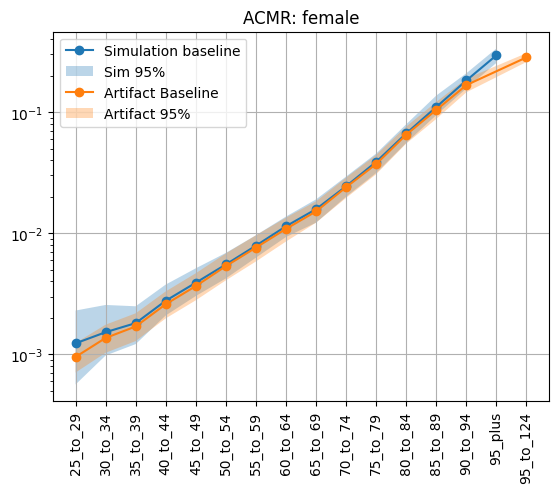

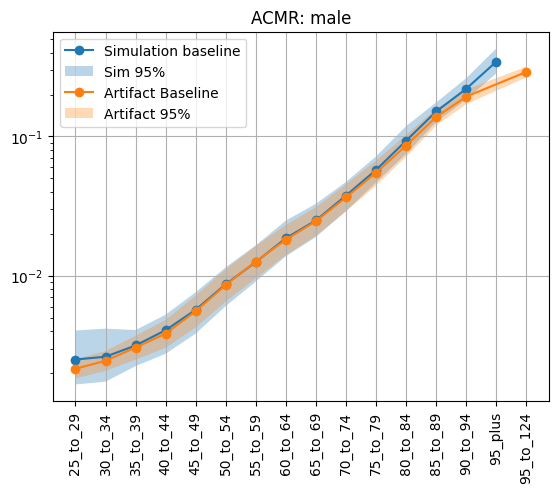

In [41]:
with PdfPages('model12_acmr_artifact_and_sim.pdf') as pdf:
    for sex in result_summary_allyears.sex.unique():
        plt.figure() 
        subdata = result_summary_allyears.loc[(result_summary_allyears.sex==sex)]
        plt.plot(subdata['age'], subdata['mean'], marker='o')
        plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        subdata2 = art_acmr.loc[(art_acmr.sex==sex)]
        plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
        plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
        plt.title(f'ACMR: {sex}') 
        plt.xticks(rotation=90) 
        plt.grid()
        plt.yscale('log')
        pdf.savefig(bbox_inches='tight')
        plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

### Cause Specific Mortality Rates

#### Stroke

In [42]:
art_csmr = load_artifact_data('cause', 'ischemic_stroke', 'cause_specific_mortality_rate') 
art_csmr['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_acmr.age_start,art_acmr.age_end)]
art_csmr.head()

,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,location,measure,age_group
0,female,25.0,30.0,2019,2020,0.000002,0.000001,0.000003,Alabama,cause_specific_mortality_rate,25_to_29
1,female,30.0,35.0,2019,2020,0.000004,0.000002,0.000007,Alabama,cause_specific_mortality_rate,30_to_34
2,female,35.0,40.0,2019,2020,0.000006,0.000003,0.000009,Alabama,cause_specific_mortality_rate,35_to_39
3,female,40.0,45.0,2019,2020,0.000011,0.000007,0.000016,Alabama,cause_specific_mortality_rate,40_to_44
4,female,45.0,50.0,2019,2020,0.000017,0.000011,0.000026,Alabama,cause_specific_mortality_rate,45_to_49


In [43]:
acute_rate_sum_allyear = (acute_rate_2
                      .groupby(['age', 'sex'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

In [44]:
chronic_rate_allyear = (chronic_rate
                      .groupby(['age', 'sex'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

In [45]:
acute_rate_2 = acute_rate_2.rename(columns = {'mean_rate':'acute_rate'})
chronic_rate = chronic_rate.rename(columns = {'mean_rate':'chronic_rate'})
total_stroke_rate = pd.concat([acute_rate_2, chronic_rate.chronic_rate], axis=1)
total_stroke_rate['total_rate'] = total_stroke_rate['acute_rate'] + total_stroke_rate['chronic_rate']

In [46]:
total_stroke_rate_allyear = (total_stroke_rate
                      .groupby(['age', 'sex'])
                      .total_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())
total_stroke_rate_allyear.head()

,age,sex,mean,2.5%,97.5%
0,25_to_29,female,0.000013,0.0,0.000102
1,25_to_29,male,0.000009,0.0,0.000077
2,30_to_34,female,0.000011,0.0,0.000112
3,30_to_34,male,0.000010,0.0,0.000078
4,35_to_39,female,0.000007,0.0,0.000039


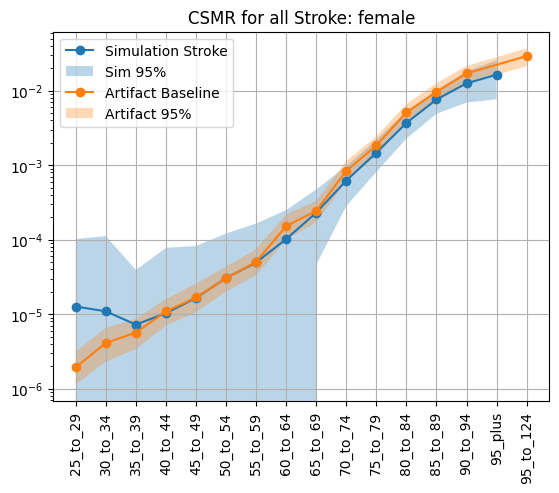

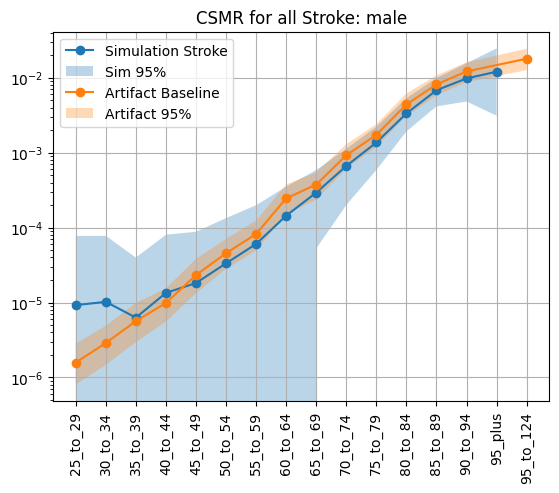

In [47]:
with PdfPages('model12_csmr_artifact_and_sim.pdf') as pdf:
    for sex in acute_rate_sum_allyear.sex.unique():
        plt.figure() 
        #subdata = acute_rate_sum_allyear.loc[(acute_rate_sum_allyear.sex==sex)]
        #plt.plot(subdata['age'], subdata['mean'], marker='o')
        #plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        #subdata2 = chronic_rate_allyear.loc[(chronic_rate_allyear.sex==sex)]
        #plt.plot(subdata2['age'], subdata2['mean'], marker='o')
        #plt.fill_between(subdata2['age'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
        subdata4 = total_stroke_rate_allyear.loc[(total_stroke_rate_allyear.sex==sex)]
        plt.plot(subdata4['age'], subdata4['mean'], marker='o')
        plt.fill_between(subdata4['age'], subdata4['2.5%'], subdata4['97.5%'], alpha=.3)
        subdata3 = art_csmr.loc[(art_csmr.sex==sex)]
        plt.plot(subdata3['age_group'], subdata3['mean'], marker='o')
        plt.fill_between(subdata3['age_group'], subdata3['2.5%'], subdata3['97.5%'], alpha=.3)
        plt.title(f'CSMR for all Stroke: {sex}') 
        plt.xticks(rotation=90) 
        plt.yscale('log')
        plt.grid()
        plt.yscale('log')
        pdf.savefig(bbox_inches='tight')
        plt.legend(['Simulation Stroke', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

#### IHD and HF Combined

In [48]:
art_csmr2 = load_artifact_data('cause', 'ischemic_heart_disease_and_heart_failure', 'cause_specific_mortality_rate') 
art_csmr2['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_csmr2.age_start,art_csmr2.age_end)]
art_csmr2.head()

,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,location,measure,age_group
0,female,25.0,30.0,2019,2020,0.000546,0.000412,0.000710,Alabama,cause_specific_mortality_rate,25_to_29
1,female,30.0,35.0,2019,2020,0.000652,0.000483,0.000838,Alabama,cause_specific_mortality_rate,30_to_34
2,female,35.0,40.0,2019,2020,0.000746,0.000545,0.000978,Alabama,cause_specific_mortality_rate,35_to_39
3,female,40.0,45.0,2019,2020,0.000804,0.000611,0.001051,Alabama,cause_specific_mortality_rate,40_to_44
4,female,45.0,50.0,2019,2020,0.001383,0.001112,0.001699,Alabama,cause_specific_mortality_rate,45_to_49


In [49]:
death_rate_cause.cause.unique()

array(['acute_ischemic_stroke', 'acute_myocardial_infarction',
       'acute_myocardial_infarction_and_heart_failure',
       'chronic_ischemic_stroke',
       'heart_failure_from_ischemic_heart_disease',
       'heart_failure_residual', 'other_causes',
       'post_myocardial_infarction'], dtype=object)

In [50]:
IHD_HF_CSMR = death_rate_cause.loc[(death_rate_cause['cause'] == 'acute_myocardial_infarction') | (death_rate_cause['cause'] == 'acute_myocardial_infarction_and_heart_failure') | (death_rate_cause['cause'] == 'heart_failure_from_ischemic_heart_disease') | (death_rate_cause['cause'] == 'heart_failure_residual') | (death_rate_cause['cause'] == 'post_myocardial_infarction')].reset_index()
IHD_HF_CSMR = IHD_HF_CSMR.groupby(['age','sex','year','input_draw']).value.sum().reset_index()
IHD_HF_CSMR = IHD_HF_CSMR.merge(per_time_group[['age','sex','year','input_draw','ptvalue']], on=['age','sex','year','input_draw'])
IHD_HF_CSMR['mean_rate'] = IHD_HF_CSMR['value'] / IHD_HF_CSMR['ptvalue']
IHD_HF_CSMR_allyear = (IHD_HF_CSMR
                      .groupby(['age', 'sex'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())
IHD_HF_CSMR_allyear

,age,sex,mean,2.5%,97.5%
0,25_to_29,female,0.000823,0.000309,0.001724
1,25_to_29,male,0.001146,0.000449,0.002275
2,30_to_34,female,0.000801,0.000397,0.001652
3,30_to_34,male,0.001166,0.000575,0.002670
...,...,...,...,...,...
26,90_to_94,female,0.114906,0.075871,0.152166
27,90_to_94,male,0.172526,0.132048,0.207354
28,95_plus,female,0.151782,0.108836,0.192820
29,95_plus,male,0.250172,0.180654,0.312595


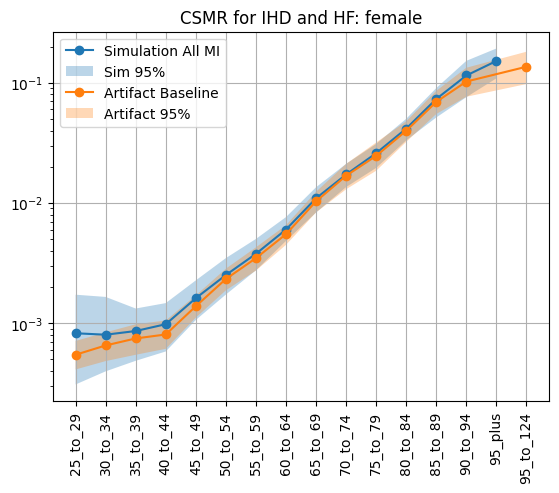

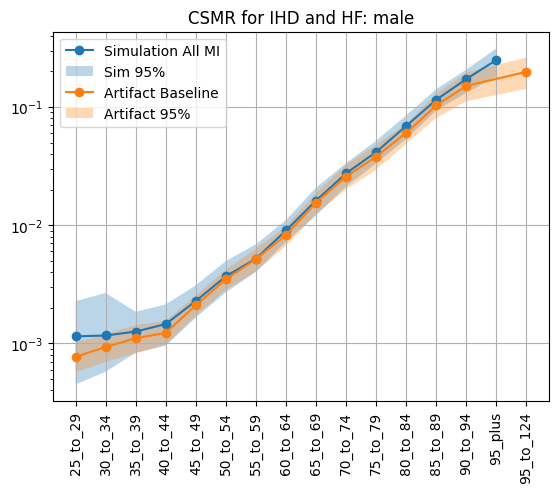

In [51]:
for sex in IHD_HF_CSMR_allyear.sex.unique():
    plt.figure() 
    subdata = IHD_HF_CSMR_allyear.loc[(IHD_HF_CSMR_allyear.sex==sex)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata3 = art_csmr2.loc[(art_csmr2.sex==sex)]
    plt.plot(subdata3['age_group'], subdata3['mean'], marker='o')
    plt.fill_between(subdata3['age_group'], subdata3['2.5%'], subdata3['97.5%'], alpha=.3)
    plt.title(f'CSMR for IHD and HF: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation All MI', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

#### Incidence Rates for Stroke

In [52]:
art_inc = load_artifact_data('cause', 'ischemic_stroke', 'incidence_rate')
art_inc['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_inc.age_start,art_inc.age_end)]
art_inc.head()

,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,location,measure,age_group
0,female,25.0,30.0,2019,2020,0.000116,0.000050,0.000225,Alabama,incidence_rate,25_to_29
1,female,30.0,35.0,2019,2020,0.000163,0.000091,0.000266,Alabama,incidence_rate,30_to_34
2,female,35.0,40.0,2019,2020,0.000232,0.000128,0.000381,Alabama,incidence_rate,35_to_39
3,female,40.0,45.0,2019,2020,0.000370,0.000242,0.000552,Alabama,incidence_rate,40_to_44
4,female,45.0,50.0,2019,2020,0.000579,0.000343,0.000939,Alabama,incidence_rate,45_to_49


In [53]:
tran_rate_sum_allyear = (tran_rate
                 .groupby(['age', 'sex', 'year'])
                 .rate.describe(percentiles=[.025, 0.5, .975])
                 .filter(['50%', '2.5%', '97.5%'])
                 .reset_index())
tran_rate_sum_allyear.head()

,age,sex,year,50%,2.5%,97.5%
0,25_to_29,female,2023,0.000168,0.0,0.001859
1,25_to_29,female,2024,0.000113,0.0,0.001801
2,25_to_29,female,2025,0.000076,0.0,0.001810
3,25_to_29,female,2026,0.000153,0.0,0.001684
4,25_to_29,female,2027,0.000173,0.0,0.002007


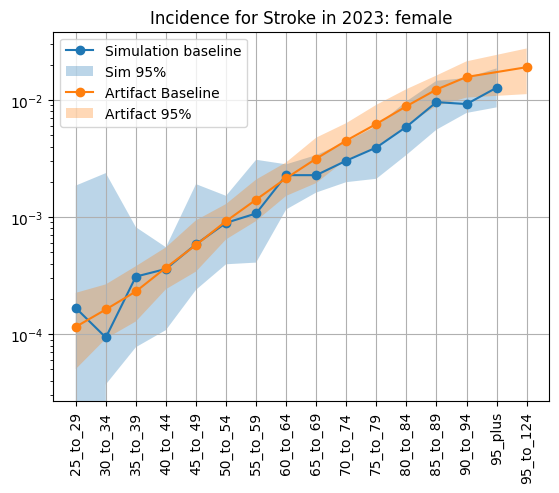

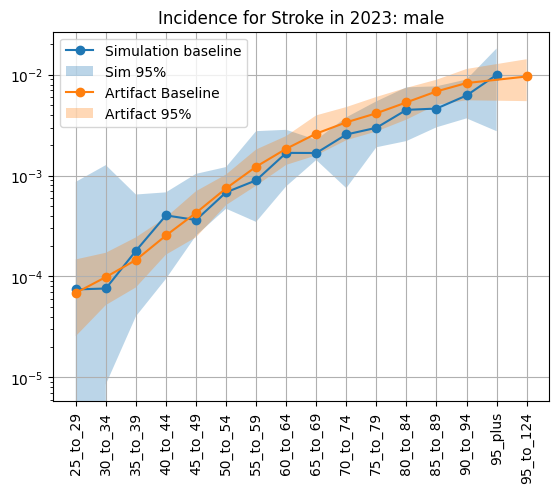

In [54]:
with PdfPages('model12_inc_artifact_and_sim.pdf') as pdf:
    for sex in tran_rate_sum_allyear.sex.unique():
        plt.figure() 
        subdata = tran_rate_sum_allyear.loc[(tran_rate_sum_allyear.sex==sex) & (tran_rate_sum_allyear.year==2023)]
        plt.plot(subdata['age'], subdata['50%'], marker='o')
        plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        subdata2 = art_inc.loc[(art_inc.sex==sex)]
        plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
        plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
        plt.title(f'Incidence for Stroke in 2023: {sex}') 
        plt.xticks(rotation=90) 
        plt.grid()
        plt.yscale('log')
        pdf.savefig(bbox_inches='tight')
        plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

#### Incidence Rates for MI

In [55]:
art_inc_acute_MI = load_artifact_data('cause', 'acute_myocardial_infarction', 'incidence_rate')
art_inc_acute_MI['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_inc_acute_MI.age_start,art_inc_acute_MI.age_end)]
art_inc_acute_MI.head()

,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,location,measure,age_group
0,female,25.0,30.0,2019,2020,0.000453,0.000285,0.000617,Alabama,incidence_rate,25_to_29
1,female,30.0,35.0,2019,2020,0.000512,0.000347,0.000685,Alabama,incidence_rate,30_to_34
2,female,35.0,40.0,2019,2020,0.000428,0.000297,0.000583,Alabama,incidence_rate,35_to_39
3,female,40.0,45.0,2019,2020,0.000541,0.000415,0.000692,Alabama,incidence_rate,40_to_44
4,female,45.0,50.0,2019,2020,0.000853,0.000652,0.001114,Alabama,incidence_rate,45_to_49


In [56]:
groupby_cols2 = ['age', 'sex', 'input_draw']
tran_rate_MI_HF = tran_rate_MI_HF.groupby(groupby_cols2).sum() / per_time_sus_MI.groupby(groupby_cols2).sum()
tran_rate_MI_HF = (tran_rate_MI_HF.groupby([c for c in groupby_cols2 if c != 'input_draw'])
                   .value.describe(percentiles=[0.025, 0.5, 0.975])
                   .filter(['mean','50%', '2.5%', '97.5%']))
                 
tran_rate_MI_HF.head()

mean  50%  2.5%     97.5%
age      sex                                      
25_to_29 female  2.194795e-07  0.0   0.0  0.000002
         male    0.000000e+00  0.0   0.0  0.000000
30_to_34 female  0.000000e+00  0.0   0.0  0.000000
         male    6.422317e-07  0.0   0.0  0.000004
35_to_39 female  6.389335e-07  0.0   0.0  0.000002

In [57]:
groupby_cols2 = ['age', 'sex', 'input_draw']
tran_rate_MI_all = tran_rate_MI.groupby(groupby_cols2).sum() / per_time_sus_MI.groupby(groupby_cols2).sum()
tran_MI_summ_allyear = (tran_rate_MI_all.groupby([c for c in groupby_cols2 if c != 'input_draw'])
                   .value.describe(percentiles=[0.025, 0.5, 0.975])
                   .filter(['mean','50%', '2.5%', '97.5%']))
                 
tran_MI_summ_allyear.head()

mean       50%      2.5%     97.5%
age      sex                                           
25_to_29 female  0.001103  0.000784  0.000039  0.002747
         male    0.001182  0.000580  0.000056  0.003561
30_to_34 female  0.000813  0.000598  0.000113  0.002441
         male    0.001388  0.000936  0.000193  0.005036
35_to_39 female  0.000550  0.000476  0.000323  0.000882

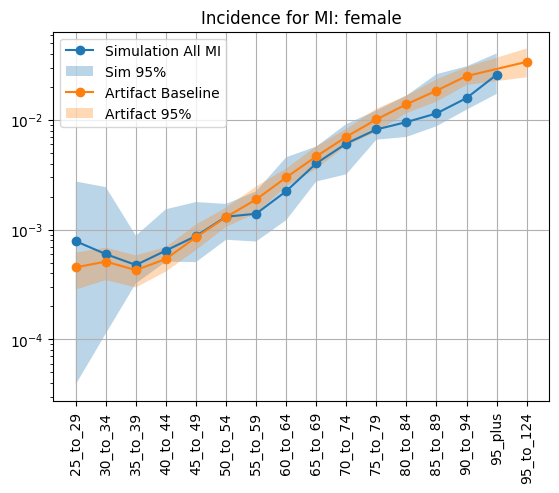

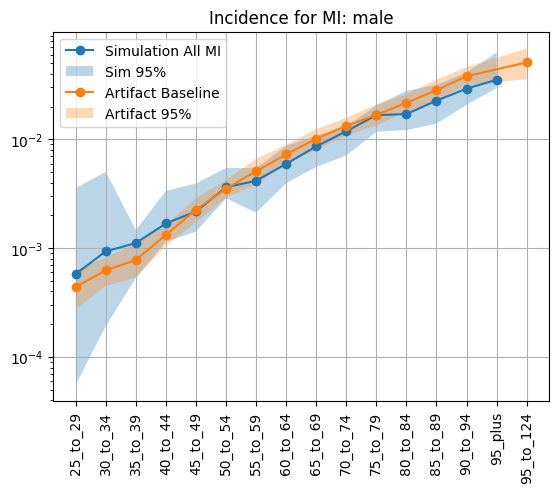

In [58]:
for sex in tran_MI_summ_allyear.index.get_level_values('sex').unique():
    plt.figure() 
    subdata = tran_MI_summ_allyear.loc[(tran_MI_summ_allyear.index.get_level_values('sex')==sex)]
    plt.plot(subdata.index.get_level_values('age'), subdata['50%'], marker='o')
    plt.fill_between(subdata.index.get_level_values('age'), subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata3 = art_inc_acute_MI.loc[(art_inc_acute_MI.sex==sex)]
    plt.plot(subdata3['age_group'], subdata3['mean'], marker='o')
    plt.fill_between(subdata3['age_group'], subdata3['2.5%'], subdata3['97.5%'], alpha=.3)
    plt.title(f'Incidence for MI: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation All MI', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

### Incidence Rates for Heart Failure IHD

In [59]:
art_inc_HF_IHD = load_artifact_data('cause', 'heart_failure_from_ischemic_heart_disease', 'incidence_rate')
art_inc_HF_IHD['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_inc_HF_IHD.age_start,art_inc_HF_IHD.age_end)]
art_inc_HF_IHD.head()

,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,location,measure,age_group
0,female,25.0,30.0,2019,2020,0.000057,0.000041,0.000075,Alabama,incidence_rate,25_to_29
1,female,30.0,35.0,2019,2020,0.000081,0.000060,0.000104,Alabama,incidence_rate,30_to_34
2,female,35.0,40.0,2019,2020,0.000089,0.000056,0.000130,Alabama,incidence_rate,35_to_39
3,female,40.0,45.0,2019,2020,0.000185,0.000138,0.000239,Alabama,incidence_rate,40_to_44
4,female,45.0,50.0,2019,2020,0.000497,0.000408,0.000590,Alabama,incidence_rate,45_to_49


In [60]:
per_time_sus_HF = person_time.loc[(person_time['state'].isin(['ischemic_heart_disease_and_heart_failure_susceptible_to_ischemic_heart_disease_and_heart_failure','ischemic_heart_disease_and_heart_failure_post_myocardial_infarction','ischemic_heart_disease_and_heart_failure_acute_myocardial_infarction_and_heart_failure']))].reset_index()
tran_rate_HF_IHD = tran.loc[(tran['transition'].isin(['ischemic_heart_disease_and_heart_failure_acute_myocardial_infarction_and_heart_failure_to_heart_failure_from_ischemic_heart_disease','ischemic_heart_disease_and_heart_failure_post_myocardial_infarction_to_heart_failure_from_ischemic_heart_disease','ischemic_heart_disease_and_heart_failure_susceptible_to_ischemic_heart_disease_and_heart_failure_to_heart_failure_from_ischemic_heart_disease']))].reset_index()
groupby_cols = ['age', 'sex', 'input_draw']
tran_rate_HF_IHD = tran_rate_HF_IHD.groupby(groupby_cols).sum() / per_time_sus_HF.groupby(groupby_cols).sum()
tran_rate_HF_IHD_allyear = (tran_rate_HF_IHD.groupby([c for c in groupby_cols if c != 'input_draw'])
                   .value.describe(percentiles=[0.025, 0.975])
                   .filter(['mean', '2.5%', '97.5%']))
                 
tran_rate_HF_IHD_allyear.head()

mean      2.5%     97.5%
age      sex                                 
25_to_29 female  0.000069  0.000040  0.000099
         male    0.000133  0.000095  0.000163
30_to_34 female  0.000090  0.000073  0.000109
         male    0.000178  0.000146  0.000231
35_to_39 female  0.000093  0.000068  0.000124

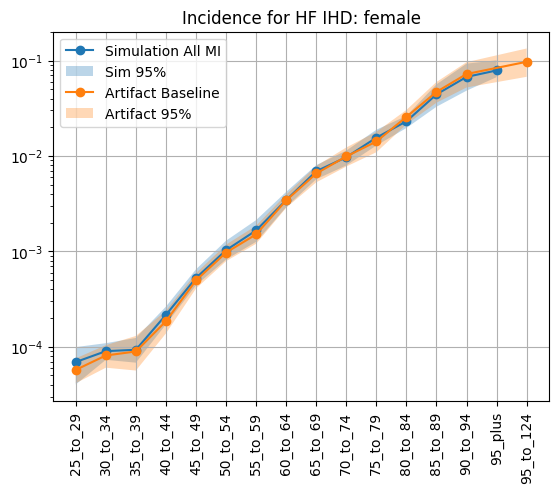

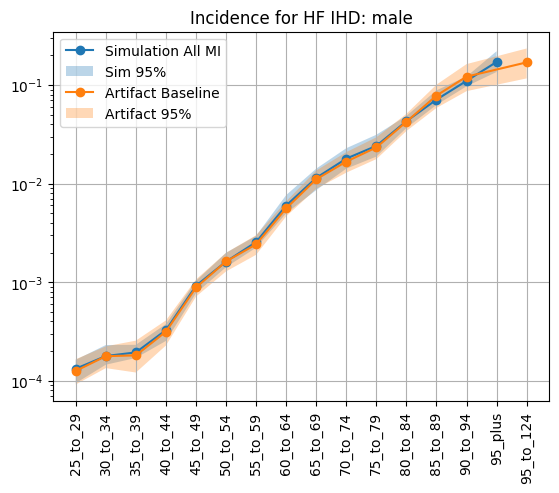

In [61]:
for sex in tran_rate_HF_IHD_allyear.index.get_level_values('sex').unique():
    plt.figure() 
    subdata = tran_rate_HF_IHD_allyear.loc[(tran_rate_HF_IHD_allyear.index.get_level_values('sex')==sex)]
    plt.plot(subdata.index.get_level_values('age'), subdata['mean'], marker='o')
    plt.fill_between(subdata.index.get_level_values('age'), subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata3 = art_inc_HF_IHD.loc[(art_inc_HF_IHD.sex==sex)]
    plt.plot(subdata3['age_group'], subdata3['mean'], marker='o')
    plt.fill_between(subdata3['age_group'], subdata3['2.5%'], subdata3['97.5%'], alpha=.3)
    plt.title(f'Incidence for HF IHD: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation All MI', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

### Incidence Rates for Heart Failure Residual

In [62]:
art_inc_HF_resid = load_artifact_data('cause', 'heart_failure_residual', 'incidence_rate')
art_inc_HF_resid['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_inc_HF_resid.age_start,art_inc_HF_resid.age_end)]
art_inc_HF_resid.head()

,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,location,measure,age_group
0,female,25.0,30.0,2019,2020,0.000601,0.000435,0.000792,Alabama,incidence_rate,25_to_29
1,female,30.0,35.0,2019,2020,0.000568,0.000423,0.000728,Alabama,incidence_rate,30_to_34
2,female,35.0,40.0,2019,2020,0.000395,0.000249,0.000574,Alabama,incidence_rate,35_to_39
3,female,40.0,45.0,2019,2020,0.000683,0.000509,0.000880,Alabama,incidence_rate,40_to_44
4,female,45.0,50.0,2019,2020,0.001313,0.001078,0.001558,Alabama,incidence_rate,45_to_49


In [63]:
per_time_sus_HF = person_time.loc[(person_time['state'].isin(['ischemic_heart_disease_and_heart_failure_susceptible_to_ischemic_heart_disease_and_heart_failure']))].reset_index()
tran_rate_HF_resid = tran.loc[(tran['transition'].isin(['ischemic_heart_disease_and_heart_failure_susceptible_to_ischemic_heart_disease_and_heart_failure_to_heart_failure_residual']))].reset_index()
groupby_cols = ['age', 'sex', 'input_draw']
tran_rate_HF_resid = tran_rate_HF_resid.groupby(groupby_cols).sum() / per_time_sus_HF.groupby(groupby_cols).sum()
tran_rate_HF_resid_allyear = (tran_rate_HF_resid.groupby([c for c in groupby_cols if c != 'input_draw'])
                   .value.describe(percentiles=[0.025, 0.975])
                   .filter(['mean', '2.5%', '97.5%']))
                 
tran_rate_HF_resid_allyear.head()

mean      2.5%     97.5%
age      sex                                 
25_to_29 female  0.000693  0.000435  0.000883
         male    0.000935  0.000742  0.001022
30_to_34 female  0.000659  0.000440  0.000768
         male    0.000822  0.000697  0.001025
35_to_39 female  0.000467  0.000382  0.000546

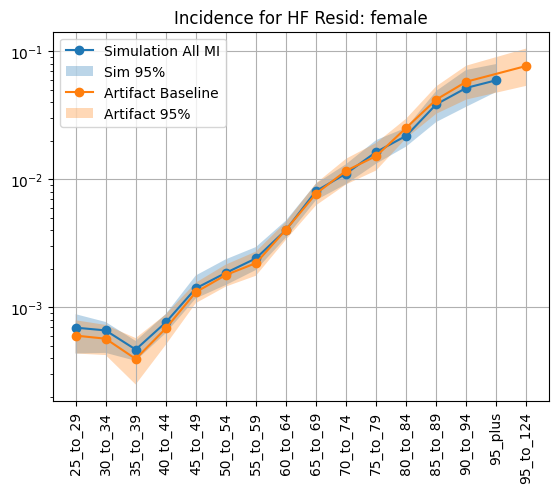

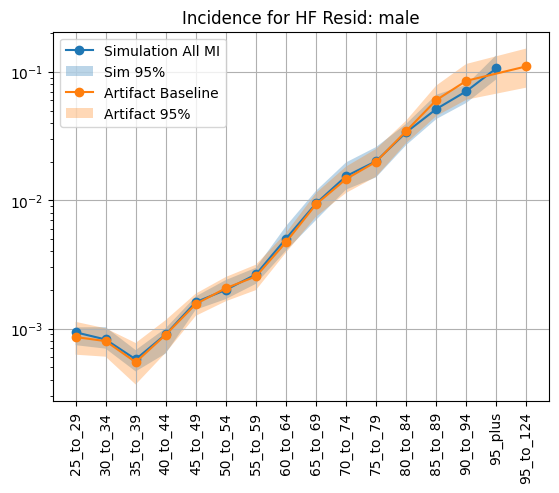

In [64]:
for sex in tran_rate_HF_resid_allyear.index.get_level_values('sex').unique():
    plt.figure() 
    subdata = tran_rate_HF_resid_allyear.loc[(tran_rate_HF_resid_allyear.index.get_level_values('sex')==sex)]
    plt.plot(subdata.index.get_level_values('age'), subdata['mean'], marker='o')
    plt.fill_between(subdata.index.get_level_values('age'), subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata3 = art_inc_HF_resid.loc[(art_inc_HF_resid.sex==sex)]
    plt.plot(subdata3['age_group'], subdata3['mean'], marker='o')
    plt.fill_between(subdata3['age_group'], subdata3['2.5%'], subdata3['97.5%'], alpha=.3)
    plt.title(f'Incidence for HF Resid: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation All MI', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

Matches the artifact but the artifact looks weird for the youngest folks 

#### Prevalence Rates

In [65]:
prev_chronic_rate_sum_allyear = (prev_chronic_rate
                 .groupby(['age', 'sex'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())

In [66]:
art_prev = load_artifact_data('sequela', 'chronic_ischemic_stroke', 'prevalence')
art_prev['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_prev.age_start,art_prev.age_end)]
art_prev.head()

,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,location,measure,age_group
0,female,25.0,30.0,2019,2020,0.004986,0.003708,0.006410,Alabama,prevalence,25_to_29
1,female,30.0,35.0,2019,2020,0.006119,0.004613,0.007857,Alabama,prevalence,30_to_34
2,female,35.0,40.0,2019,2020,0.007737,0.005971,0.010016,Alabama,prevalence,35_to_39
3,female,40.0,45.0,2019,2020,0.010115,0.007659,0.013100,Alabama,prevalence,40_to_44
4,female,45.0,50.0,2019,2020,0.014078,0.010695,0.018031,Alabama,prevalence,45_to_49


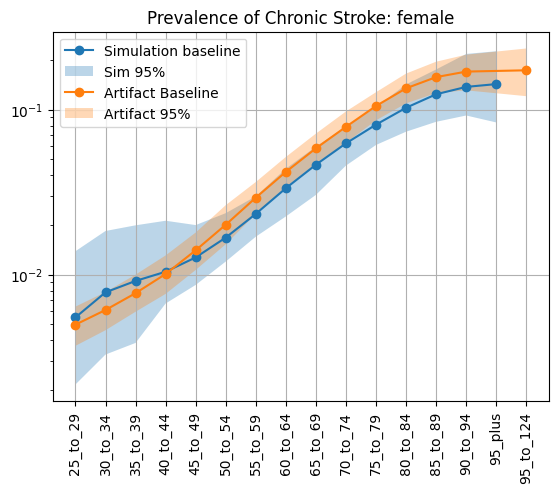

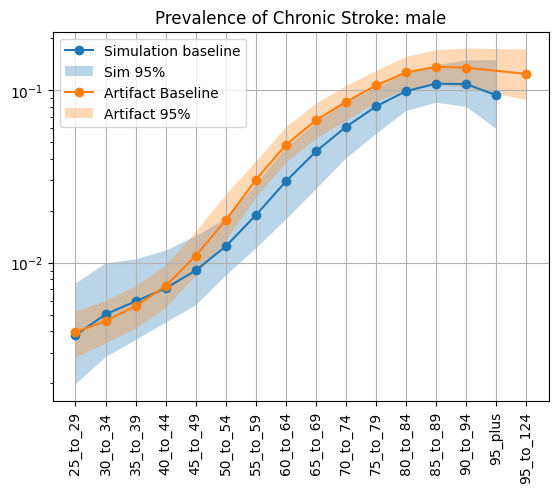

In [67]:
for sex in prev_chronic_rate_sum_allyear.sex.unique():
    plt.figure() 
    subdata = prev_chronic_rate_sum_allyear.loc[(prev_chronic_rate_sum_allyear.sex==sex)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = art_prev.loc[(art_prev.sex==sex)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'Prevalence of Chronic Stroke: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

In [68]:
prev_acute_rate_sum_allyear = (prev_acute_rate
                 .groupby(['age', 'sex'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())

In [69]:
art_prev2 = load_artifact_data('sequela', 'acute_ischemic_stroke', 'prevalence')
art_prev2['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_prev2.age_start,art_prev2.age_end)]

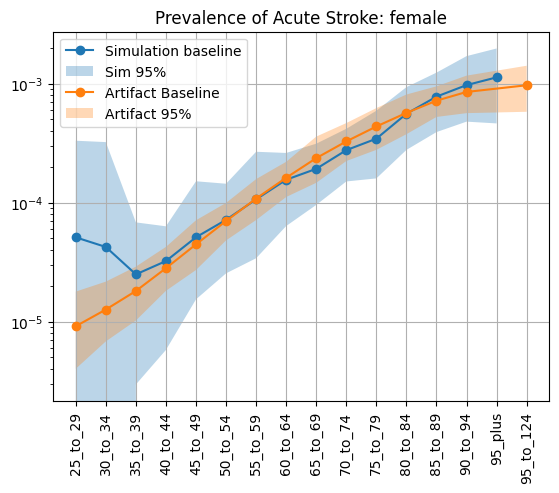

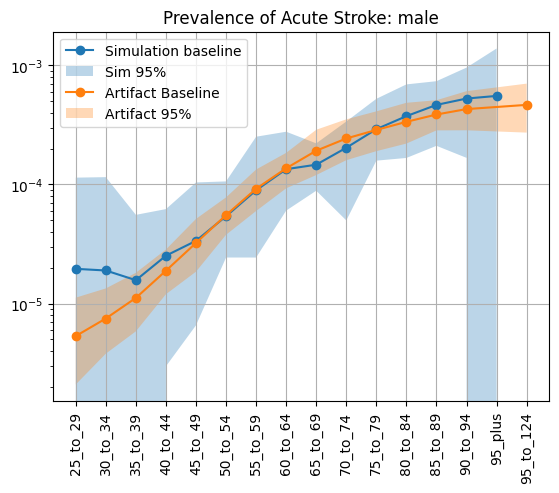

In [70]:
for sex in prev_acute_rate_sum_allyear.sex.unique():
    plt.figure() 
    subdata = prev_acute_rate_sum_allyear.loc[(prev_acute_rate_sum_allyear.sex==sex)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = art_prev2.loc[(art_prev2.sex==sex)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'Prevalence of Acute Stroke: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

#### Prevalence of Post MI

In [71]:
art_prev3 = load_artifact_data('cause', 'post_myocardial_infarction', 'prevalence')
art_prev3['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_prev3.age_start,art_prev3.age_end)]
art_prev3.head()

,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,location,measure,age_group
0,female,25.0,30.0,2019,2020,0.001227,0.000904,0.001572,Alabama,prevalence,25_to_29
1,female,30.0,35.0,2019,2020,0.002536,0.001865,0.003277,Alabama,prevalence,30_to_34
2,female,35.0,40.0,2019,2020,0.004012,0.003125,0.005009,Alabama,prevalence,35_to_39
3,female,40.0,45.0,2019,2020,0.005660,0.004450,0.007101,Alabama,prevalence,40_to_44
4,female,45.0,50.0,2019,2020,0.007613,0.005996,0.009425,Alabama,prevalence,45_to_49


In [72]:
prev_post_MI_sum_allyear = (prev_post_MI
                 .groupby(['age', 'sex', 'year'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())
prev_post_MI_sum_allyear.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,female,2023,0.002420,0.000824,0.004559
1,25_to_29,female,2024,0.002727,0.000578,0.005432
2,25_to_29,female,2025,0.002926,0.000449,0.005923
3,25_to_29,female,2026,0.003055,0.000255,0.006553
4,25_to_29,female,2027,0.003191,0.000239,0.006805


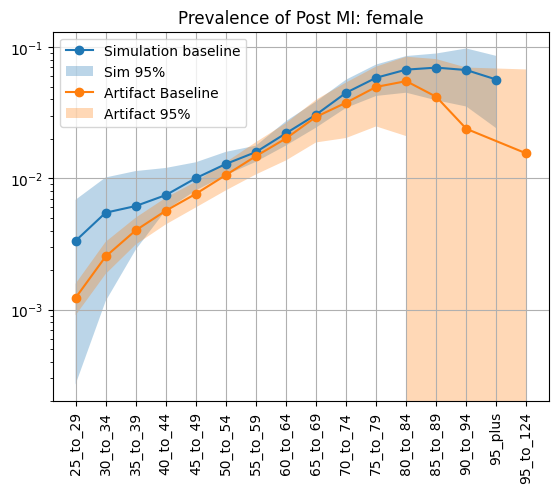

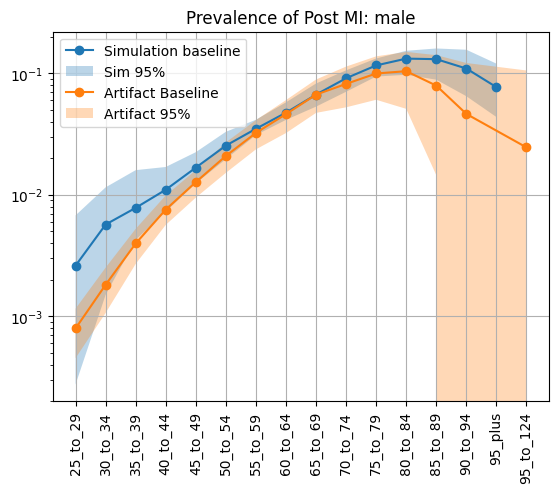

In [73]:
##Can try plotting the median 

for sex in prev_post_MI_sum_allyear.sex.unique():
    plt.figure() 
    subdata = prev_post_MI_sum_allyear.loc[(prev_post_MI_sum_allyear.sex==sex) & (prev_post_MI_sum_allyear.year == 2029)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = art_prev3.loc[(art_prev3.sex==sex)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'Prevalence of Post MI: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

In [74]:
## 2023 looks pretty good but 2040 looks pretty bad 

#### Prevalence of Acute MI

In [75]:
art_prev4 = load_artifact_data('cause', 'acute_myocardial_infarction', 'prevalence')
art_prev4['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_prev4.age_start,art_prev4.age_end)]
art_prev4.head()

,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,location,measure,age_group
0,female,25.0,30.0,2019,2020,0.000029,0.000019,0.000040,Alabama,prevalence,25_to_29
1,female,30.0,35.0,2019,2020,0.000036,0.000024,0.000048,Alabama,prevalence,30_to_34
2,female,35.0,40.0,2019,2020,0.000031,0.000022,0.000042,Alabama,prevalence,35_to_39
3,female,40.0,45.0,2019,2020,0.000037,0.000028,0.000048,Alabama,prevalence,40_to_44
4,female,45.0,50.0,2019,2020,0.000058,0.000044,0.000074,Alabama,prevalence,45_to_49


In [76]:
prev_acute_MI_sum_allyear = (prev_acute_MI
                 .groupby(['age', 'sex'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())
prev_acute_MI_sum_allyear.head()

,age,sex,mean,2.5%,97.5%
0,25_to_29,female,0.000084,0.000000,0.000240
1,25_to_29,male,0.000089,0.000000,0.000306
2,30_to_34,female,0.000062,0.000006,0.000221
3,30_to_34,male,0.000106,0.000007,0.000471
4,35_to_39,female,0.000042,0.000015,0.000084


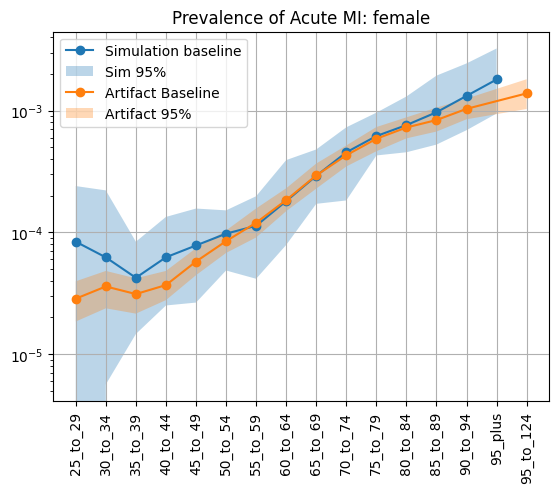

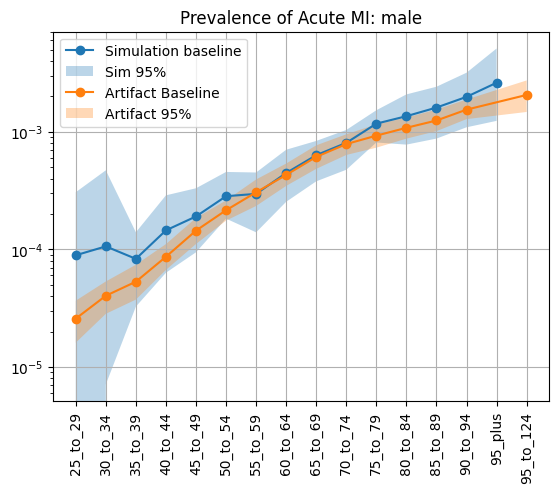

In [77]:
for sex in prev_acute_MI_sum_allyear.sex.unique():
    plt.figure() 
    subdata = prev_acute_MI_sum_allyear.loc[(prev_acute_MI_sum_allyear.sex==sex)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = art_prev4.loc[(art_prev4.sex==sex)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'Prevalence of Acute MI: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

### Prevalence of Heart Failure IHD

In [78]:
art_prev_hf_ihd = load_artifact_data('cause', 'heart_failure_from_ischemic_heart_disease', 'prevalence')
art_prev_hf_ihd['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_prev_hf_ihd.age_start,art_prev_hf_ihd.age_end)]
art_prev_hf_ihd.head()

,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,location,measure,age_group
0,female,25.0,30.0,2019,2020,0.000224,0.000169,0.000288,Alabama,prevalence,25_to_29
1,female,30.0,35.0,2019,2020,0.000471,0.000345,0.000624,Alabama,prevalence,30_to_34
2,female,35.0,40.0,2019,2020,0.000680,0.000515,0.000866,Alabama,prevalence,35_to_39
3,female,40.0,45.0,2019,2020,0.000746,0.000582,0.000948,Alabama,prevalence,40_to_44
4,female,45.0,50.0,2019,2020,0.001574,0.001337,0.001821,Alabama,prevalence,45_to_49


In [79]:
prev_HF_IHD = per_time_state.loc[(per_time_state['state'] == 'ischemic_heart_disease_and_heart_failure_heart_failure_from_ischemic_heart_disease')].reset_index()
prev_HF_IHD = prev_HF_IHD.rename(columns = {'ptvalue':'value'})
prev_HF_IHD = prev_HF_IHD.merge(per_time_group[['age','sex','year','input_draw','ptvalue']], on=['age','sex','year','input_draw'])
prev_HF_IHD['rate']= prev_HF_IHD['value'] / prev_HF_IHD['ptvalue']
prev_HF_IHD_allyear = (prev_HF_IHD
                 .groupby(['age', 'sex'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())
prev_HF_IHD_allyear.head()

,age,sex,mean,2.5%,97.5%
0,25_to_29,female,0.000189,0.000053,0.000366
1,25_to_29,male,0.000387,0.000141,0.000648
2,30_to_34,female,0.000394,0.000153,0.000646
3,30_to_34,male,0.000754,0.000426,0.001224
4,35_to_39,female,0.000502,0.000240,0.000786


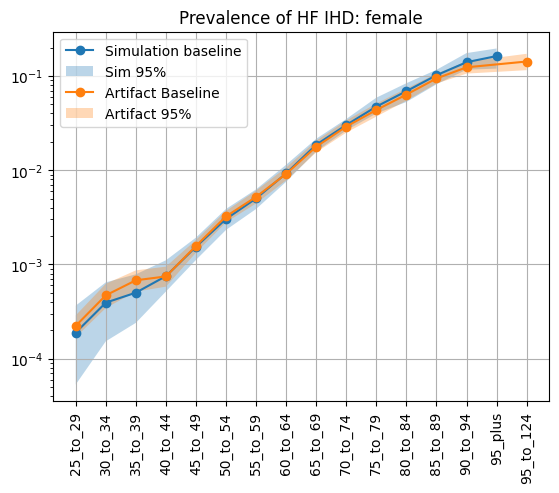

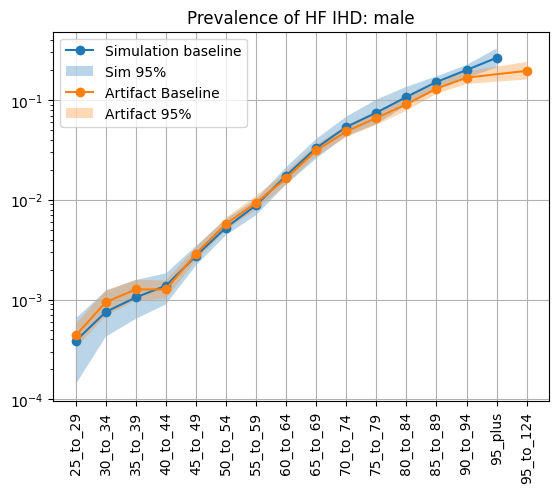

In [80]:
for sex in prev_HF_IHD_allyear.sex.unique():
    plt.figure() 
    subdata = prev_HF_IHD_allyear.loc[(prev_HF_IHD_allyear.sex==sex)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = art_prev_hf_ihd.loc[(art_prev_hf_ihd.sex==sex)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'Prevalence of HF IHD: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

## Prevalence of Heart Failure Residual

In [81]:
art_prev_hf_resid = load_artifact_data('cause', 'heart_failure_residual', 'prevalence')
art_prev_hf_resid['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_prev_hf_resid.age_start,art_prev_hf_resid.age_end)]
art_prev_hf_resid.head()

,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,location,measure,age_group
0,female,25.0,30.0,2019,2020,0.002341,0.001774,0.003021,Alabama,prevalence,25_to_29
1,female,30.0,35.0,2019,2020,0.003290,0.002414,0.004362,Alabama,prevalence,30_to_34
2,female,35.0,40.0,2019,2020,0.002993,0.002267,0.003813,Alabama,prevalence,35_to_39
3,female,40.0,45.0,2019,2020,0.002735,0.002134,0.003475,Alabama,prevalence,40_to_44
4,female,45.0,50.0,2019,2020,0.004126,0.003504,0.004772,Alabama,prevalence,45_to_49


In [82]:
prev_HF_resid = per_time_state.loc[(per_time_state['state'] == 'ischemic_heart_disease_and_heart_failure_heart_failure_residual')].reset_index()
prev_HF_resid = prev_HF_resid.rename(columns = {'ptvalue':'value'})
prev_HF_resid = prev_HF_resid.merge(per_time_group[['age','sex','year','input_draw','ptvalue']], on=['age','sex','year','input_draw'])
prev_HF_resid['rate']= prev_HF_resid['value'] / prev_HF_resid['ptvalue']
prev_HF_resid_allyear = (prev_HF_resid
                 .groupby(['age', 'sex'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())
prev_HF_resid_allyear.head()

,age,sex,mean,2.5%,97.5%
0,25_to_29,female,0.002602,0.001808,0.003558
1,25_to_29,male,0.003213,0.002495,0.004226
2,30_to_34,female,0.003636,0.002467,0.005136
3,30_to_34,male,0.004365,0.003225,0.005866
4,35_to_39,female,0.003599,0.002560,0.004763


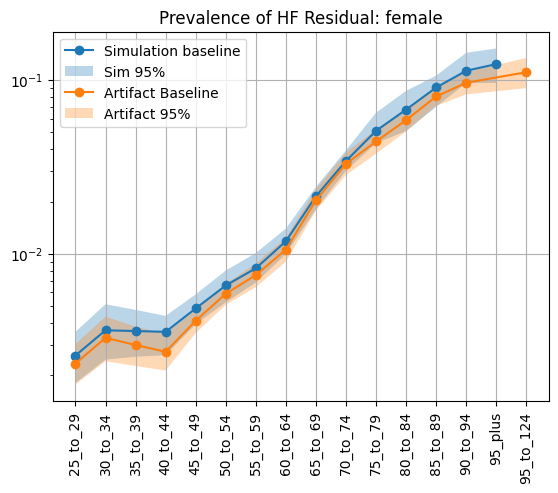

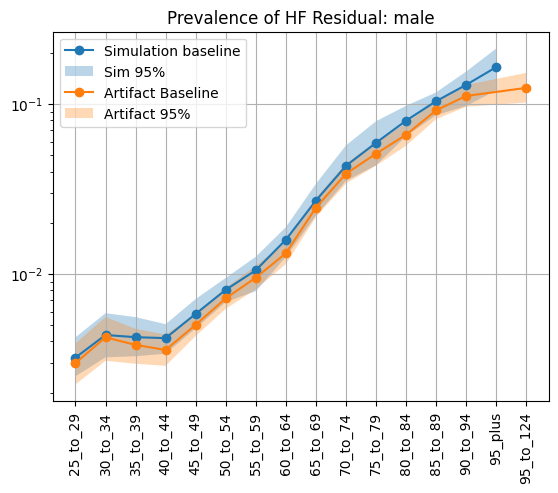

In [83]:
for sex in prev_HF_resid_allyear.sex.unique():
    plt.figure() 
    subdata = prev_HF_resid_allyear.loc[(prev_HF_resid_allyear.sex==sex)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = art_prev_hf_resid.loc[(art_prev_hf_resid.sex==sex)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'Prevalence of HF Residual: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

## Excess Mortality Rate

#### Acute Stroke

In [84]:
art_emr = load_artifact_data('sequela', 'acute_ischemic_stroke', 'excess_mortality_rate')
art_emr['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_emr.age_start,art_emr.age_end)]
art_emr.head()

,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,location,measure,age_group
0,female,25.0,30.0,2019,2020,0.309244,0.212204,0.442095,Alabama,excess_mortality_rate,25_to_29
1,female,30.0,35.0,2019,2020,0.293380,0.198519,0.416337,Alabama,excess_mortality_rate,30_to_34
2,female,35.0,40.0,2019,2020,0.323206,0.234077,0.432974,Alabama,excess_mortality_rate,35_to_39
3,female,40.0,45.0,2019,2020,0.322984,0.238528,0.438779,Alabama,excess_mortality_rate,40_to_44
4,female,45.0,50.0,2019,2020,0.292713,0.203912,0.393501,Alabama,excess_mortality_rate,45_to_49


In [85]:
prev_acute = per_time_state.loc[(per_time_state['state'] == 'ischemic_stroke_acute_ischemic_stroke')].reset_index()
acute_rate_emr = pd.concat([acute_rate, prev_acute.ptvalue], axis=1)
acute_rate_emr['mean_rate'] = acute_rate_emr['value'] / acute_rate_emr['ptvalue']

acute_rate_sum_allyear = (acute_rate_emr
                      .groupby(['age', 'sex'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

acute_rate_sum_allyear.head()

,age,sex,mean,2.5%,97.5%
0,25_to_29,female,0.184768,0.0,1.449405
1,25_to_29,male,0.475369,0.0,3.478571
2,30_to_34,female,0.147561,0.0,1.855238
3,30_to_34,male,0.780177,0.0,6.522321
4,35_to_39,female,0.285139,0.0,2.608929


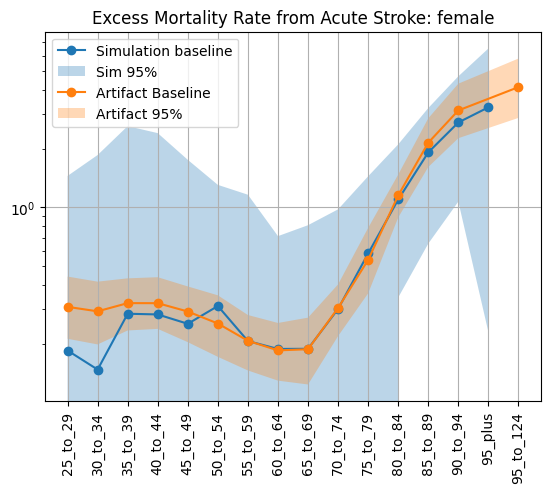

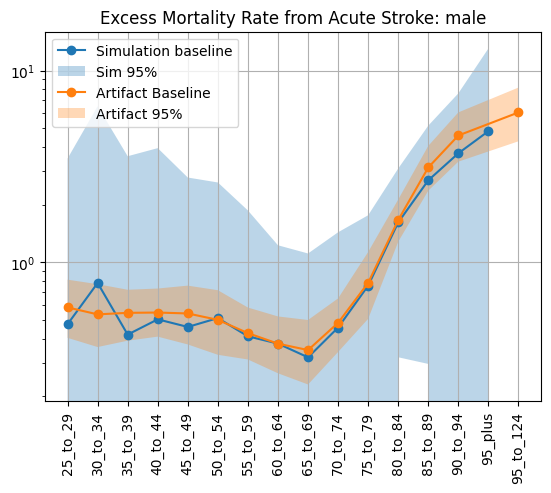

In [86]:
for sex in acute_rate_sum_allyear.sex.unique():
    plt.figure() 
    subdata = acute_rate_sum_allyear.loc[(acute_rate_sum_allyear.sex==sex)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = art_emr.loc[(art_emr.sex==sex)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'Excess Mortality Rate from Acute Stroke: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

#### Chronic Stroke

In [87]:
art_emr2 = load_artifact_data('sequela', 'chronic_ischemic_stroke', 'excess_mortality_rate')
art_emr2['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_emr2.age_start,art_emr2.age_end)]

In [88]:
chronic = per_time_state.loc[(per_time_state['state'] == 'ischemic_stroke_chronic_ischemic_stroke')].reset_index()
#chronic = chronic.rename(columns = {'value':'ptvalue'})
chronic_rate = death_rate_cause.loc[(death_rate_cause['cause'] == 'chronic_ischemic_stroke')].reset_index()
chronic_rate_emr = pd.concat([chronic_rate, chronic.ptvalue], axis=1)
chronic_rate_emr['mean_rate'] = chronic_rate_emr['value'] / chronic_rate_emr['ptvalue']
chronic_rate_emr_allyear = (chronic_rate_emr
                      .groupby(['age', 'sex'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())


chronic_rate_emr_allyear.head()

,age,sex,mean,2.5%,97.5%
0,25_to_29,female,0.000078,0.0,0.0
1,25_to_29,male,0.000000,0.0,0.0
2,30_to_34,female,0.000047,0.0,0.0
3,30_to_34,male,0.000000,0.0,0.0
4,35_to_39,female,0.000078,0.0,0.0


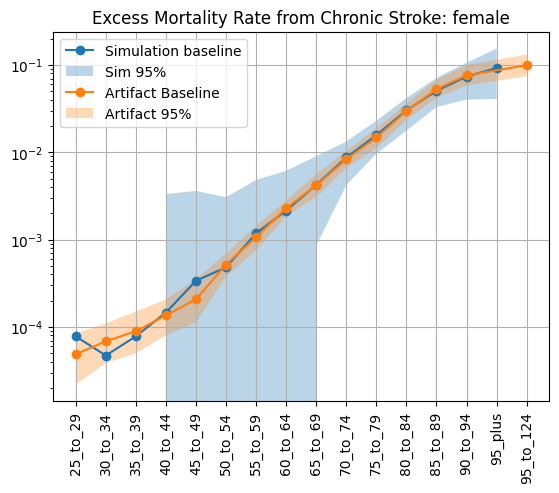

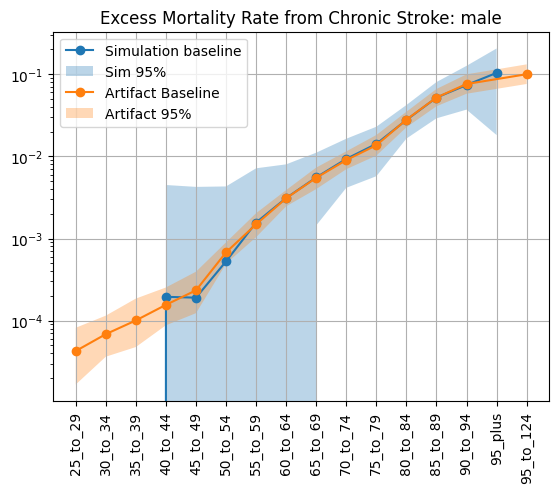

In [89]:
for sex in chronic_rate_emr_allyear.sex.unique():
    plt.figure() 
    subdata = chronic_rate_emr_allyear.loc[(chronic_rate_emr_allyear.sex==sex)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = art_emr2.loc[(art_emr2.sex==sex)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'Excess Mortality Rate from Chronic Stroke: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

#### Acute MI

In [90]:
art_emr_acuteMI = load_artifact_data('cause', 'acute_myocardial_infarction', 'excess_mortality_rate')
art_emr_acuteMI['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_emr_acuteMI.age_start,art_emr_acuteMI.age_end)]

In [91]:
acute_MI_EMR = per_time_state.loc[(per_time_state['state'] == 'ischemic_heart_disease_and_heart_failure_acute_myocardial_infarction_and_heart_failure') | ((per_time_state['state'] == 'ischemic_heart_disease_and_heart_failure_acute_myocardial_infarction'))].reset_index()
acute_MI_EMR = acute_MI_EMR.groupby(['age','year','sex','input_draw']).ptvalue.sum().reset_index()
acute_MI_emr_rate = death_rate_cause.loc[(death_rate_cause['cause'] == 'acute_myocardial_infarction_and_heart_failure') | (death_rate_cause['cause'] == 'acute_myocardial_infarction')].reset_index()
acute_MI_emr_rate = acute_MI_emr_rate.groupby(['age','year','sex','input_draw']).value.sum().reset_index()
acute_MI_emr_rate = acute_MI_emr_rate.merge(acute_MI_EMR[['age','year','sex','input_draw','ptvalue']], on=['age','year','sex','input_draw'])
acute_MI_emr_rate['mean_rate'] = acute_MI_emr_rate['value'] / acute_MI_emr_rate['ptvalue']
acute_MI_emr_rate_allyear = (acute_MI_emr_rate
                      .groupby(['age', 'sex', 'year'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())
acute_MI_emr_rate_allyear.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,female,2023,3.035841,1.913886,4.317156
1,25_to_29,female,2024,2.473801,0.381794,3.921251
2,25_to_29,female,2025,3.546987,2.030872,6.832908
3,25_to_29,female,2026,2.996202,1.739286,5.507738
4,25_to_29,female,2027,3.632484,0.395102,11.166214


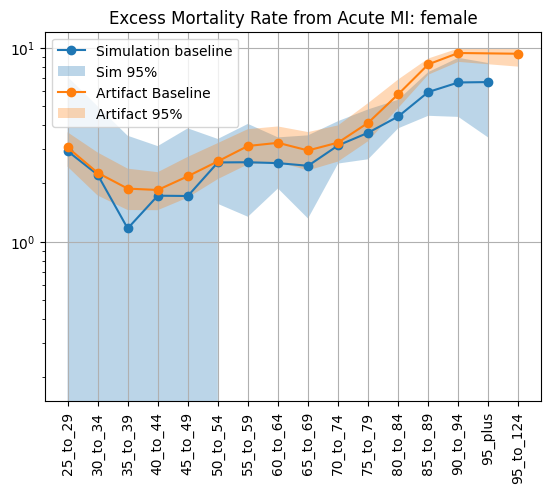

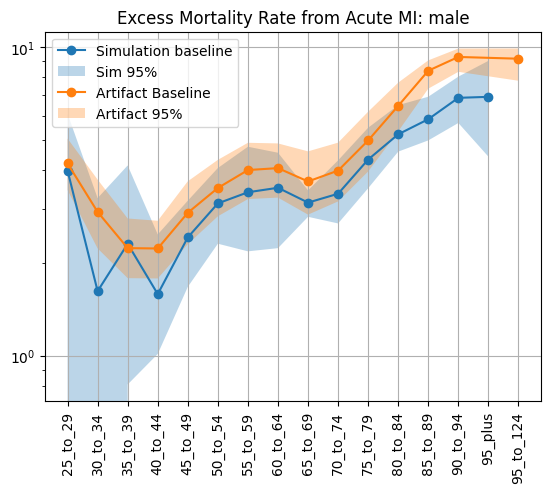

In [92]:
for sex in acute_MI_emr_rate_allyear.sex.unique():
    plt.figure() 
    subdata = acute_MI_emr_rate_allyear.loc[(acute_MI_emr_rate_allyear.sex==sex) & (acute_MI_emr_rate_allyear.year==2029)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = art_emr_acuteMI.loc[(art_emr_acuteMI.sex==sex)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'Excess Mortality Rate from Acute MI: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

#### Post MI EMR

In [93]:
post_mi_rate_emr_allyear = (post_MI_emr
                      .groupby(['age', 'sex'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())


post_mi_rate_emr_allyear.head()

,age,sex,mean,2.5%,97.5%
0,25_to_29,female,0.049917,0.0,0.187538
1,25_to_29,male,0.055038,0.0,0.169353
2,30_to_34,female,0.023794,0.0,0.055939
3,30_to_34,male,0.027119,0.0,0.064403
4,35_to_39,female,0.016344,0.0,0.042240


In [94]:
art_emr_postMI = load_artifact_data('cause', 'post_myocardial_infarction', 'excess_mortality_rate')
art_emr_postMI['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_emr_postMI.age_start,art_emr_postMI.age_end)]

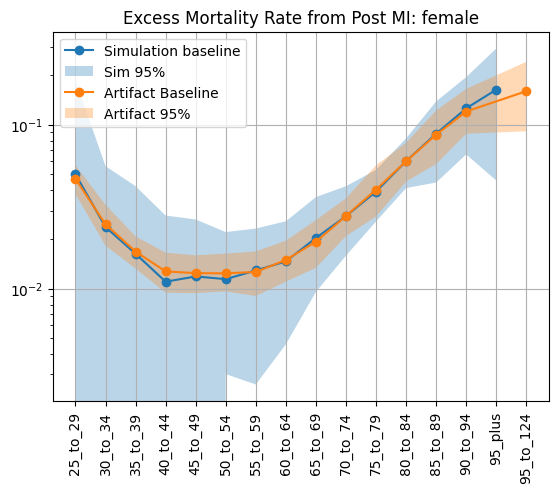

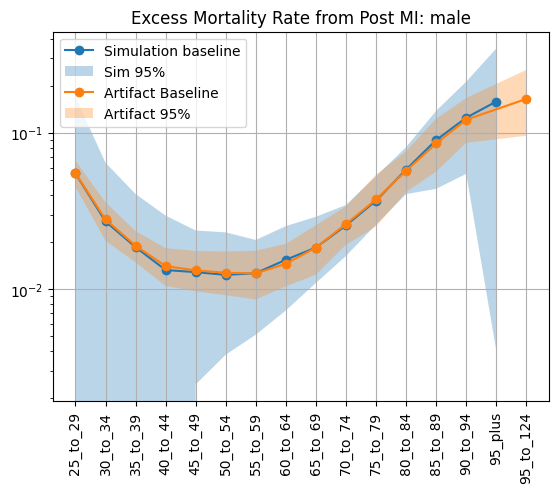

In [95]:
for sex in post_mi_rate_emr_allyear.sex.unique():
    plt.figure() 
    subdata = post_mi_rate_emr_allyear.loc[(post_mi_rate_emr_allyear.sex==sex)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = art_emr_postMI.loc[(art_emr_postMI.sex==sex)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'Excess Mortality Rate from Post MI: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

### EMR for Heart Failure

In [96]:
art_emr_HF = load_artifact_data('cause', 'heart_failure', 'excess_mortality_rate')
art_emr_HF['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_emr_HF.age_start,art_emr_HF.age_end)]
art_emr_HF.head()

,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,location,measure,age_group
0,female,25.0,30.0,2019,2020,0.157219,0.111406,0.216535,Alabama,excess_mortality_rate,25_to_29
1,female,30.0,35.0,2019,2020,0.136440,0.095899,0.187640,Alabama,excess_mortality_rate,30_to_34
2,female,35.0,40.0,2019,2020,0.169535,0.122948,0.222670,Alabama,excess_mortality_rate,35_to_39
3,female,40.0,45.0,2019,2020,0.192198,0.141037,0.254912,Alabama,excess_mortality_rate,40_to_44
4,female,45.0,50.0,2019,2020,0.204429,0.163795,0.255060,Alabama,excess_mortality_rate,45_to_49


In [97]:
HF_emr_allyear = (HF_emr
                      .groupby(['age', 'sex'])
                      .mean_rate.describe(percentiles=[.025,0.5, .975])
                      .filter(['mean','50%', '2.5%', '97.5%'])
                      .reset_index())


HF_emr_allyear.head()

,age,sex,mean,50%,2.5%,97.5%
0,25_to_29,female,0.785783,0.147955,0.0,4.484880
1,25_to_29,male,0.553941,0.184506,0.0,2.954106
2,30_to_34,female,0.428379,0.128802,0.0,2.522944
3,30_to_34,male,0.309454,0.137993,0.0,1.442711
4,35_to_39,female,0.410205,0.164740,0.0,1.822028


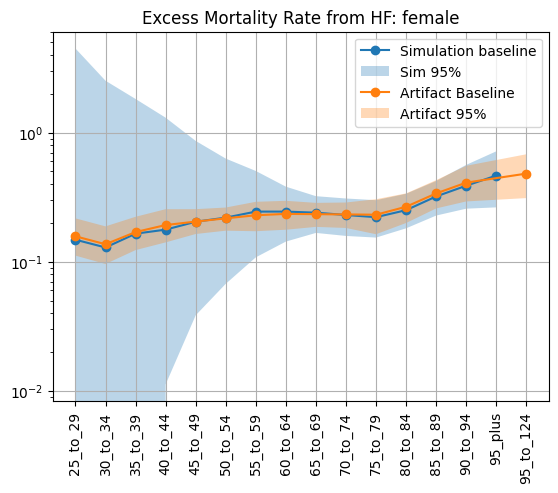

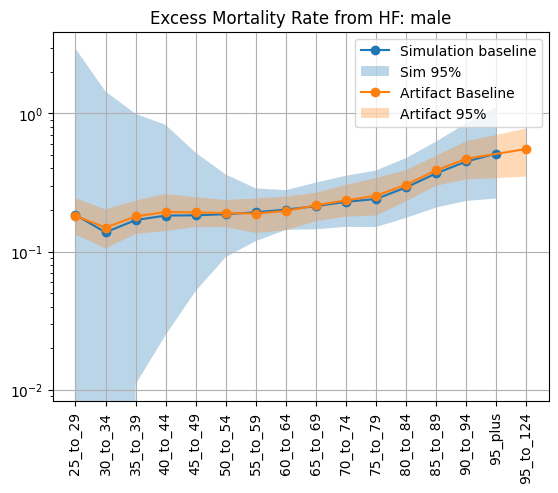

In [98]:
for sex in HF_emr_allyear.sex.unique():
    plt.figure() 
    subdata = HF_emr_allyear.loc[(HF_emr_allyear.sex==sex)]
    plt.plot(subdata['age'], subdata['50%'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = art_emr_HF.loc[(art_emr_HF.sex==sex)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'Excess Mortality Rate from HF: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

Looks a little wild in the youngest age groups but I think this is likely just due to very small sample sizes 

When I changed it to the median it matches exactly